In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
import traceback
from astropy.constants import G
import astropy.units as u
import symlib
import colossus.cosmology as cosmology

sim_colors = {
    'SymphonyLMC': sns.color_palette("colorblind")[4],
    'SymphonyMilkyWay': sns.color_palette("colorblind")[0],
    'SymphonyGroup': sns.color_palette("colorblind")[2],
    'SymphonyLCluster': sns.color_palette("colorblind")[1],
    'SymphonyCluster': sns.color_palette("colorblind")[3]
}

In [ ]:
def plot_ppsd_split_by_concentration_and_accretion(base_dir, suite_names):
    def mean_std_plot(ax, x_list, y_list, mean_param, label_prefix, color, sci=False):
        if len(x_list) == 0 or len(y_list) == 0:
            return
        x_ref = x_list[0]
        y_stack = np.stack(y_list)
        y_mean = np.nanmean(y_stack, axis=0)
        y_std = np.nanstd(y_stack, axis=0)
        param_fmt = f"{mean_param:.2e}" if sci else f"{mean_param:.2f}"
        label = f"{label_prefix} (mean={param_fmt}, N={len(y_list)})"
        ax.plot(x_ref, y_mean, color=color, lw=0.9, label=label)
        ax.fill_between(x_ref, y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)

    r_low, r_high, m_low, m_high = [], [], [], []
    Qr_low_c, Qr_high_c, Qtot_low_c, Qtot_high_c = [], [], [], []
    Qr_low_g, Qr_high_g, Qtot_low_g, Qtot_high_g = [], [], [], []
    cvir_low, cvir_high, gamma_low, gamma_high = [], [], [], []
    cvir_medians, gamma_medians = [], []

    for suite in suite_names:
        ppsd_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted([f for f in os.listdir(ppsd_dir) if f.endswith(".csv")])

        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        acc_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        cvir_df = pd.read_csv(cvir_path)
        cvir_dict = dict(zip(cvir_df["halo_id"], cvir_df["cvir"]))
        df_gamma = pd.read_csv(acc_path)
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))

        cvir_list, gamma_list = [], []
        r_list, m_list, Qr_list, Qtot_list = [], [], [], []

        for i, f in enumerate(files):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(ppsd_dir, f))
                r = df["r_scaled"].values
                m = df["m_scaled"].values
                Qr = df["Q_r"].values
                Qtot = df["Q_tot"].values

                cvir = cvir_dict.get(halo_id, np.nan)
                gamma = gamma_dict.get(halo_id, np.nan)
            except:
                continue

            r_list.append(r)
            m_list.append(m)
            Qr_list.append(Qr)
            Qtot_list.append(Qtot)
            cvir_list.append(cvir)
            gamma_list.append(gamma)

        cvir_median = np.nanmedian(cvir_list)
        gamma_median = np.nanmedian(gamma_list)
        cvir_medians.append(cvir_median)
        gamma_medians.append(gamma_median)

        for r, m, Qr, Qtot, c, g in zip(r_list, m_list, Qr_list, Qtot_list, cvir_list, gamma_list):
            if not np.all(np.isfinite(Qr)) or not np.all(np.isfinite(Qtot)):
                continue
            if c <= cvir_median:
                r_low.append(r)
                m_low.append(m)
                Qr_low_c.append(Qr)
                Qtot_low_c.append(Qtot)
                cvir_low.append(c)
            else:
                r_high.append(r)
                m_high.append(m)
                Qr_high_c.append(Qr)
                Qtot_high_c.append(Qtot)
                cvir_high.append(c)

            if g <= gamma_median:
                Qr_low_g.append(Qr)
                Qtot_low_g.append(Qtot)
                gamma_low.append(g)
            else:
                Qr_high_g.append(Qr)
                Qtot_high_g.append(Qtot)
                gamma_high.append(g)

    def finalize(axs, r_Qr, r_Qtot, m_Qr, m_Qtot,
                 low_label, high_label, colors,
                 low_param, high_param, sci=False):
        mean_std_plot(axs[0], r_low, r_Qr[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[0], r_high, r_Qr[1], high_param, high_label, colors[1], sci)
        axs[0].set_title(r"$Q_r$ vs $r$")

        mean_std_plot(axs[1], r_low, r_Qtot[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[1], r_high, r_Qtot[1], high_param, high_label, colors[1], sci)
        axs[1].set_title(r"$Q_{\rm tot}$ vs $r$")

        mean_std_plot(axs[2], m_low, m_Qr[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[2], m_high, m_Qr[1], high_param, high_label, colors[1], sci)
        axs[2].set_title(r"$Q_r$ vs $M$")

        mean_std_plot(axs[3], m_low, m_Qtot[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[3], m_high, m_Qtot[1], high_param, high_label, colors[1], sci)
        axs[3].set_title(r"$Q_{\rm tot}$ vs $M$")

        for ax in axs:
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlabel("r / Rvir" if "r" in ax.get_title() else "M / Mvir")
            ax.set_ylabel("PPSD")
            ax.grid(True, which="both", linestyle=":")
            ax.legend()

    os.makedirs(os.path.join(base_dir, "output", "combined", "figures"), exist_ok=True)

    fig_c, axes_c = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    finalize(axes_c.flatten(),
             [Qr_low_c, Qr_high_c], [Qtot_low_c, Qtot_high_c],
             [Qr_low_c, Qr_high_c], [Qtot_low_c, Qtot_high_c],
             "Low c", "High c", ["steelblue", "firebrick"],
             np.mean(cvir_low), np.mean(cvir_high), sci=False)
    fig_c.suptitle("PPSD by Concentration (Per-suite split)", fontsize=16)
    fig_c.tight_layout(rect=[0, 0, 1, 0.96])
    fig_c.savefig(os.path.join(base_dir, "output", "combined", "ppsd_profiles_by_concentration.png"))

    fig_a, axes_a = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    finalize(axes_a.flatten(),
             [Qr_low_g, Qr_high_g], [Qtot_low_g, Qtot_high_g],
             [Qr_low_g, Qr_high_g], [Qtot_low_g, Qtot_high_g],
             "Low Accretion", "High Accretion", ["seagreen", "orange"],
             np.mean(gamma_low), np.mean(gamma_high), sci=True)
    fig_a.suptitle("PPSD by Accretion Rate (Per-suite split)", fontsize=16)
    fig_a.tight_layout(rect=[0, 0, 1, 0.96])
    fig_a.savefig(os.path.join(base_dir, "output", "combined", "ppsd_profiles_by_accretion.png"))

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

plot_ppsd_split_by_concentration_and_accretion(base_dir, suite_names)

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_4856/2167717357.py:88: RuntimeWarning: Mean of empty slice
  y_mean = np.nanmean(y_interp, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


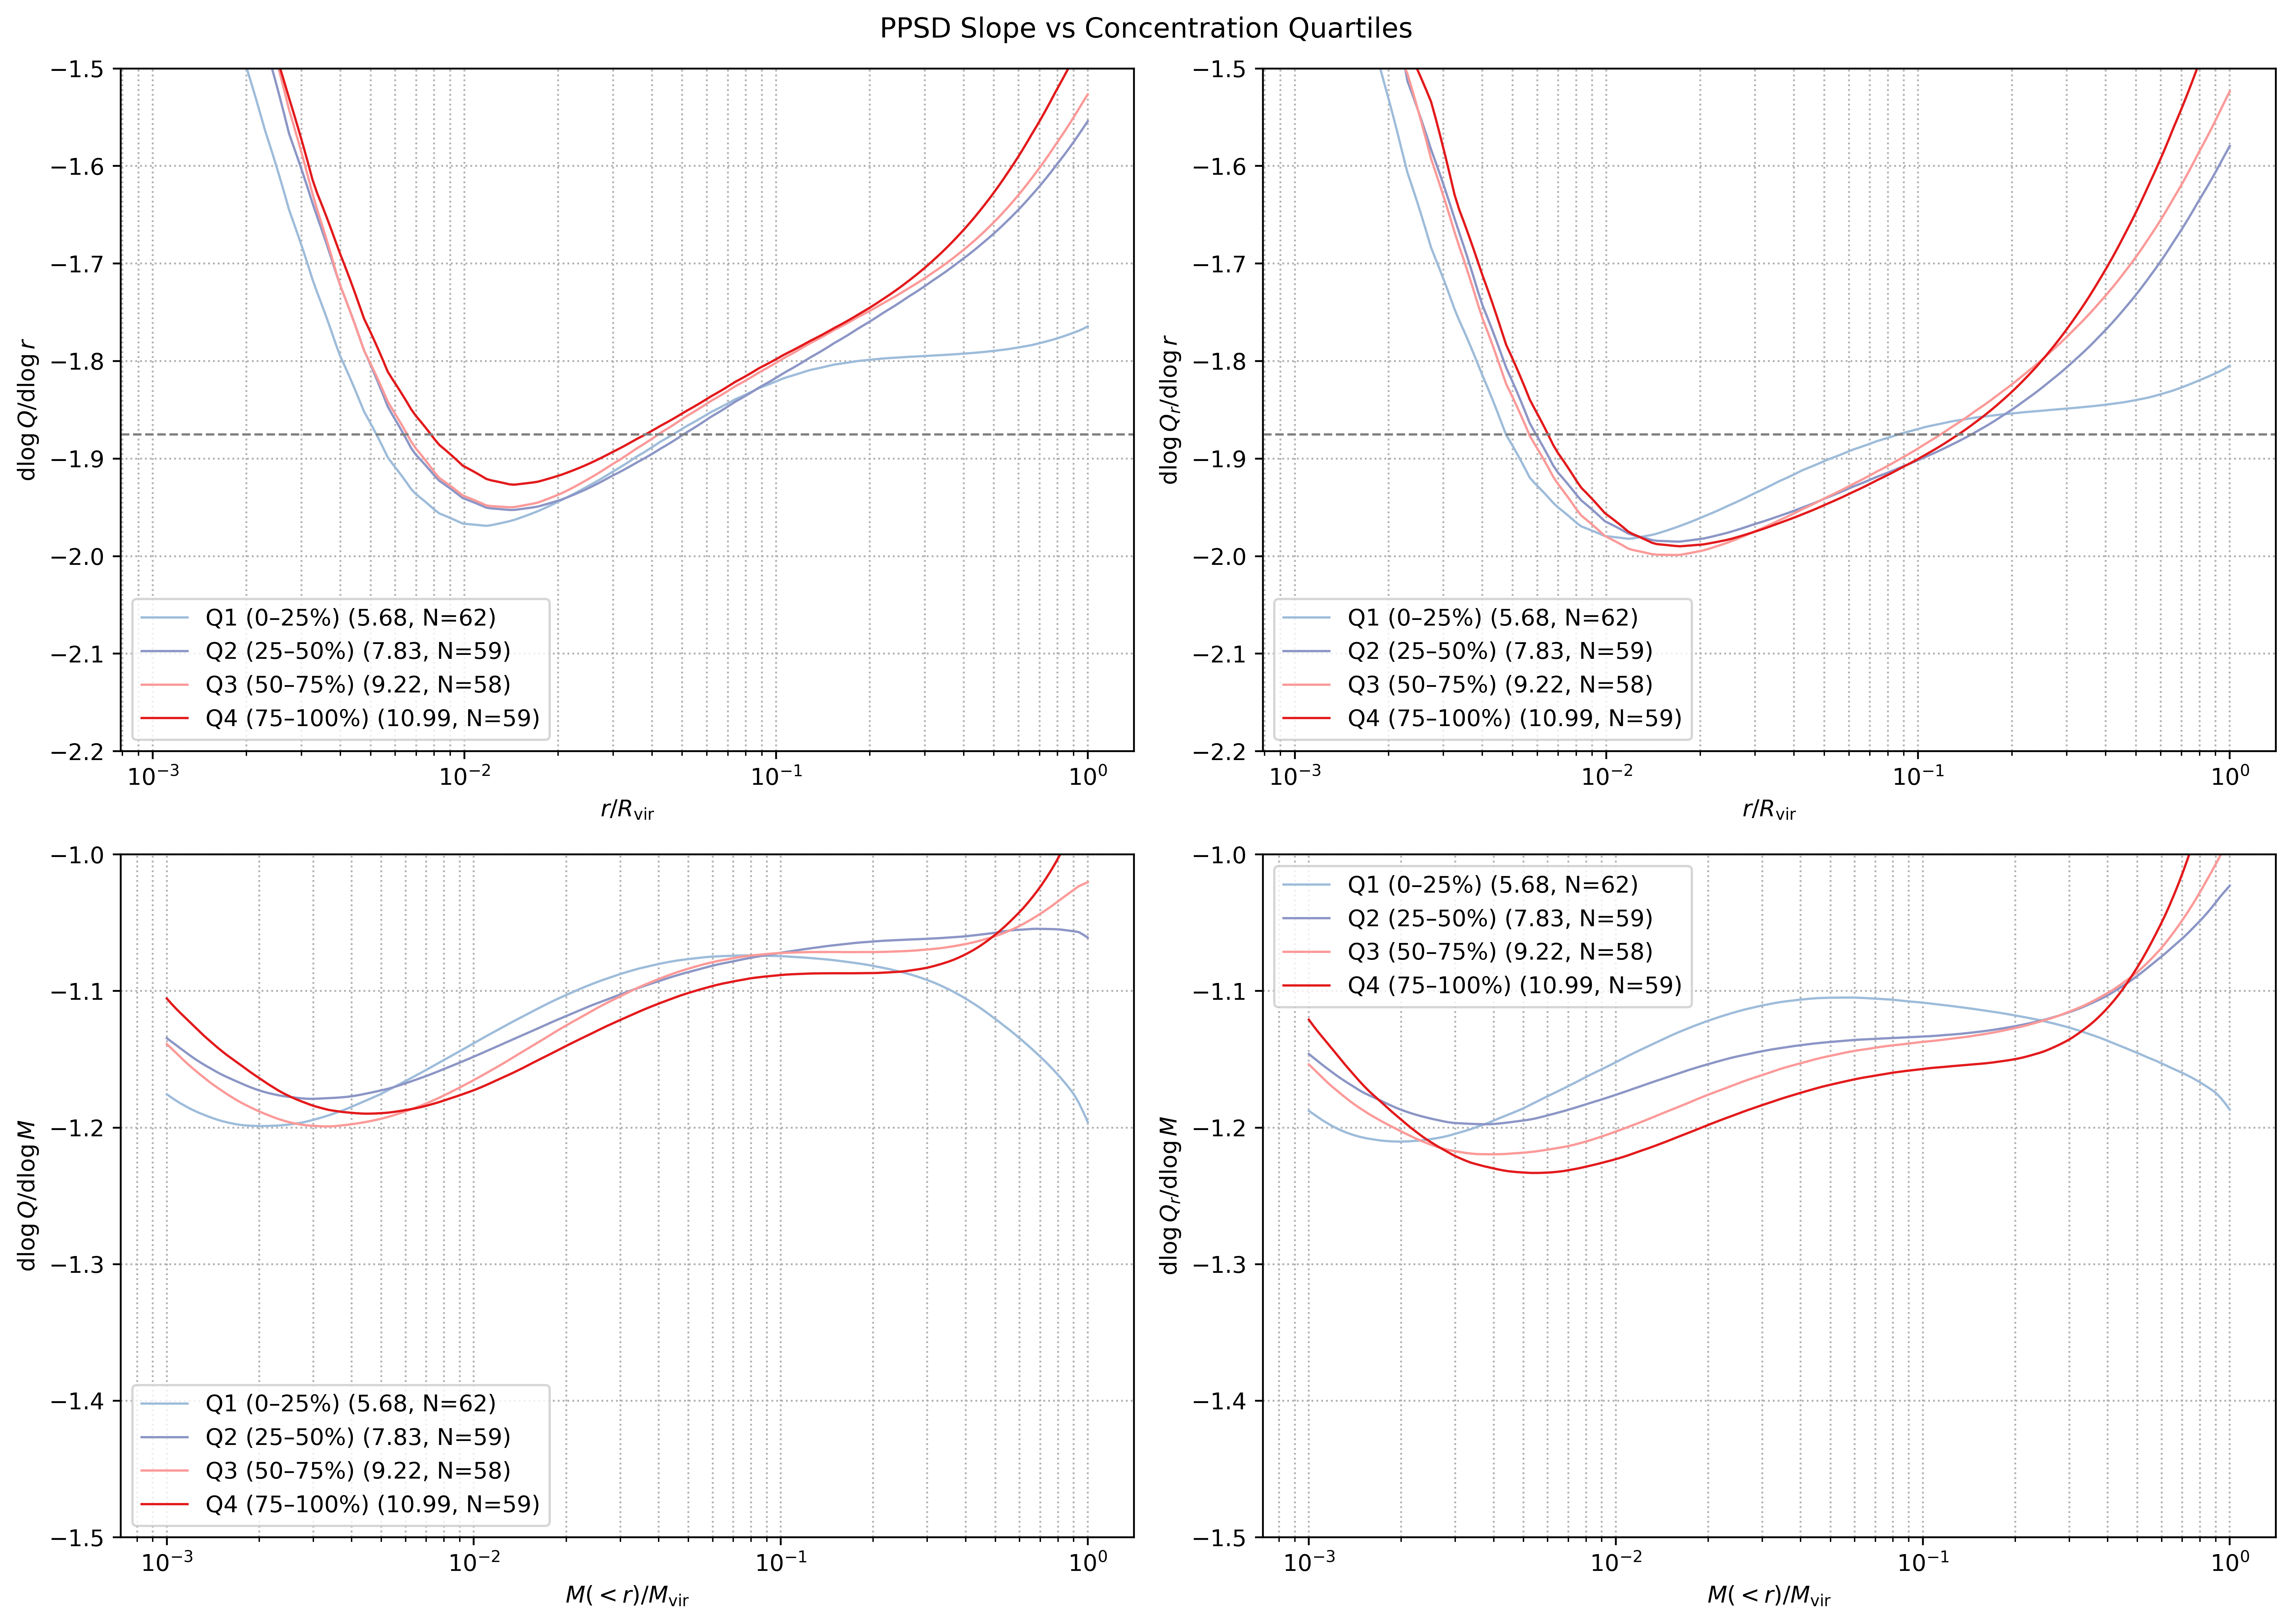

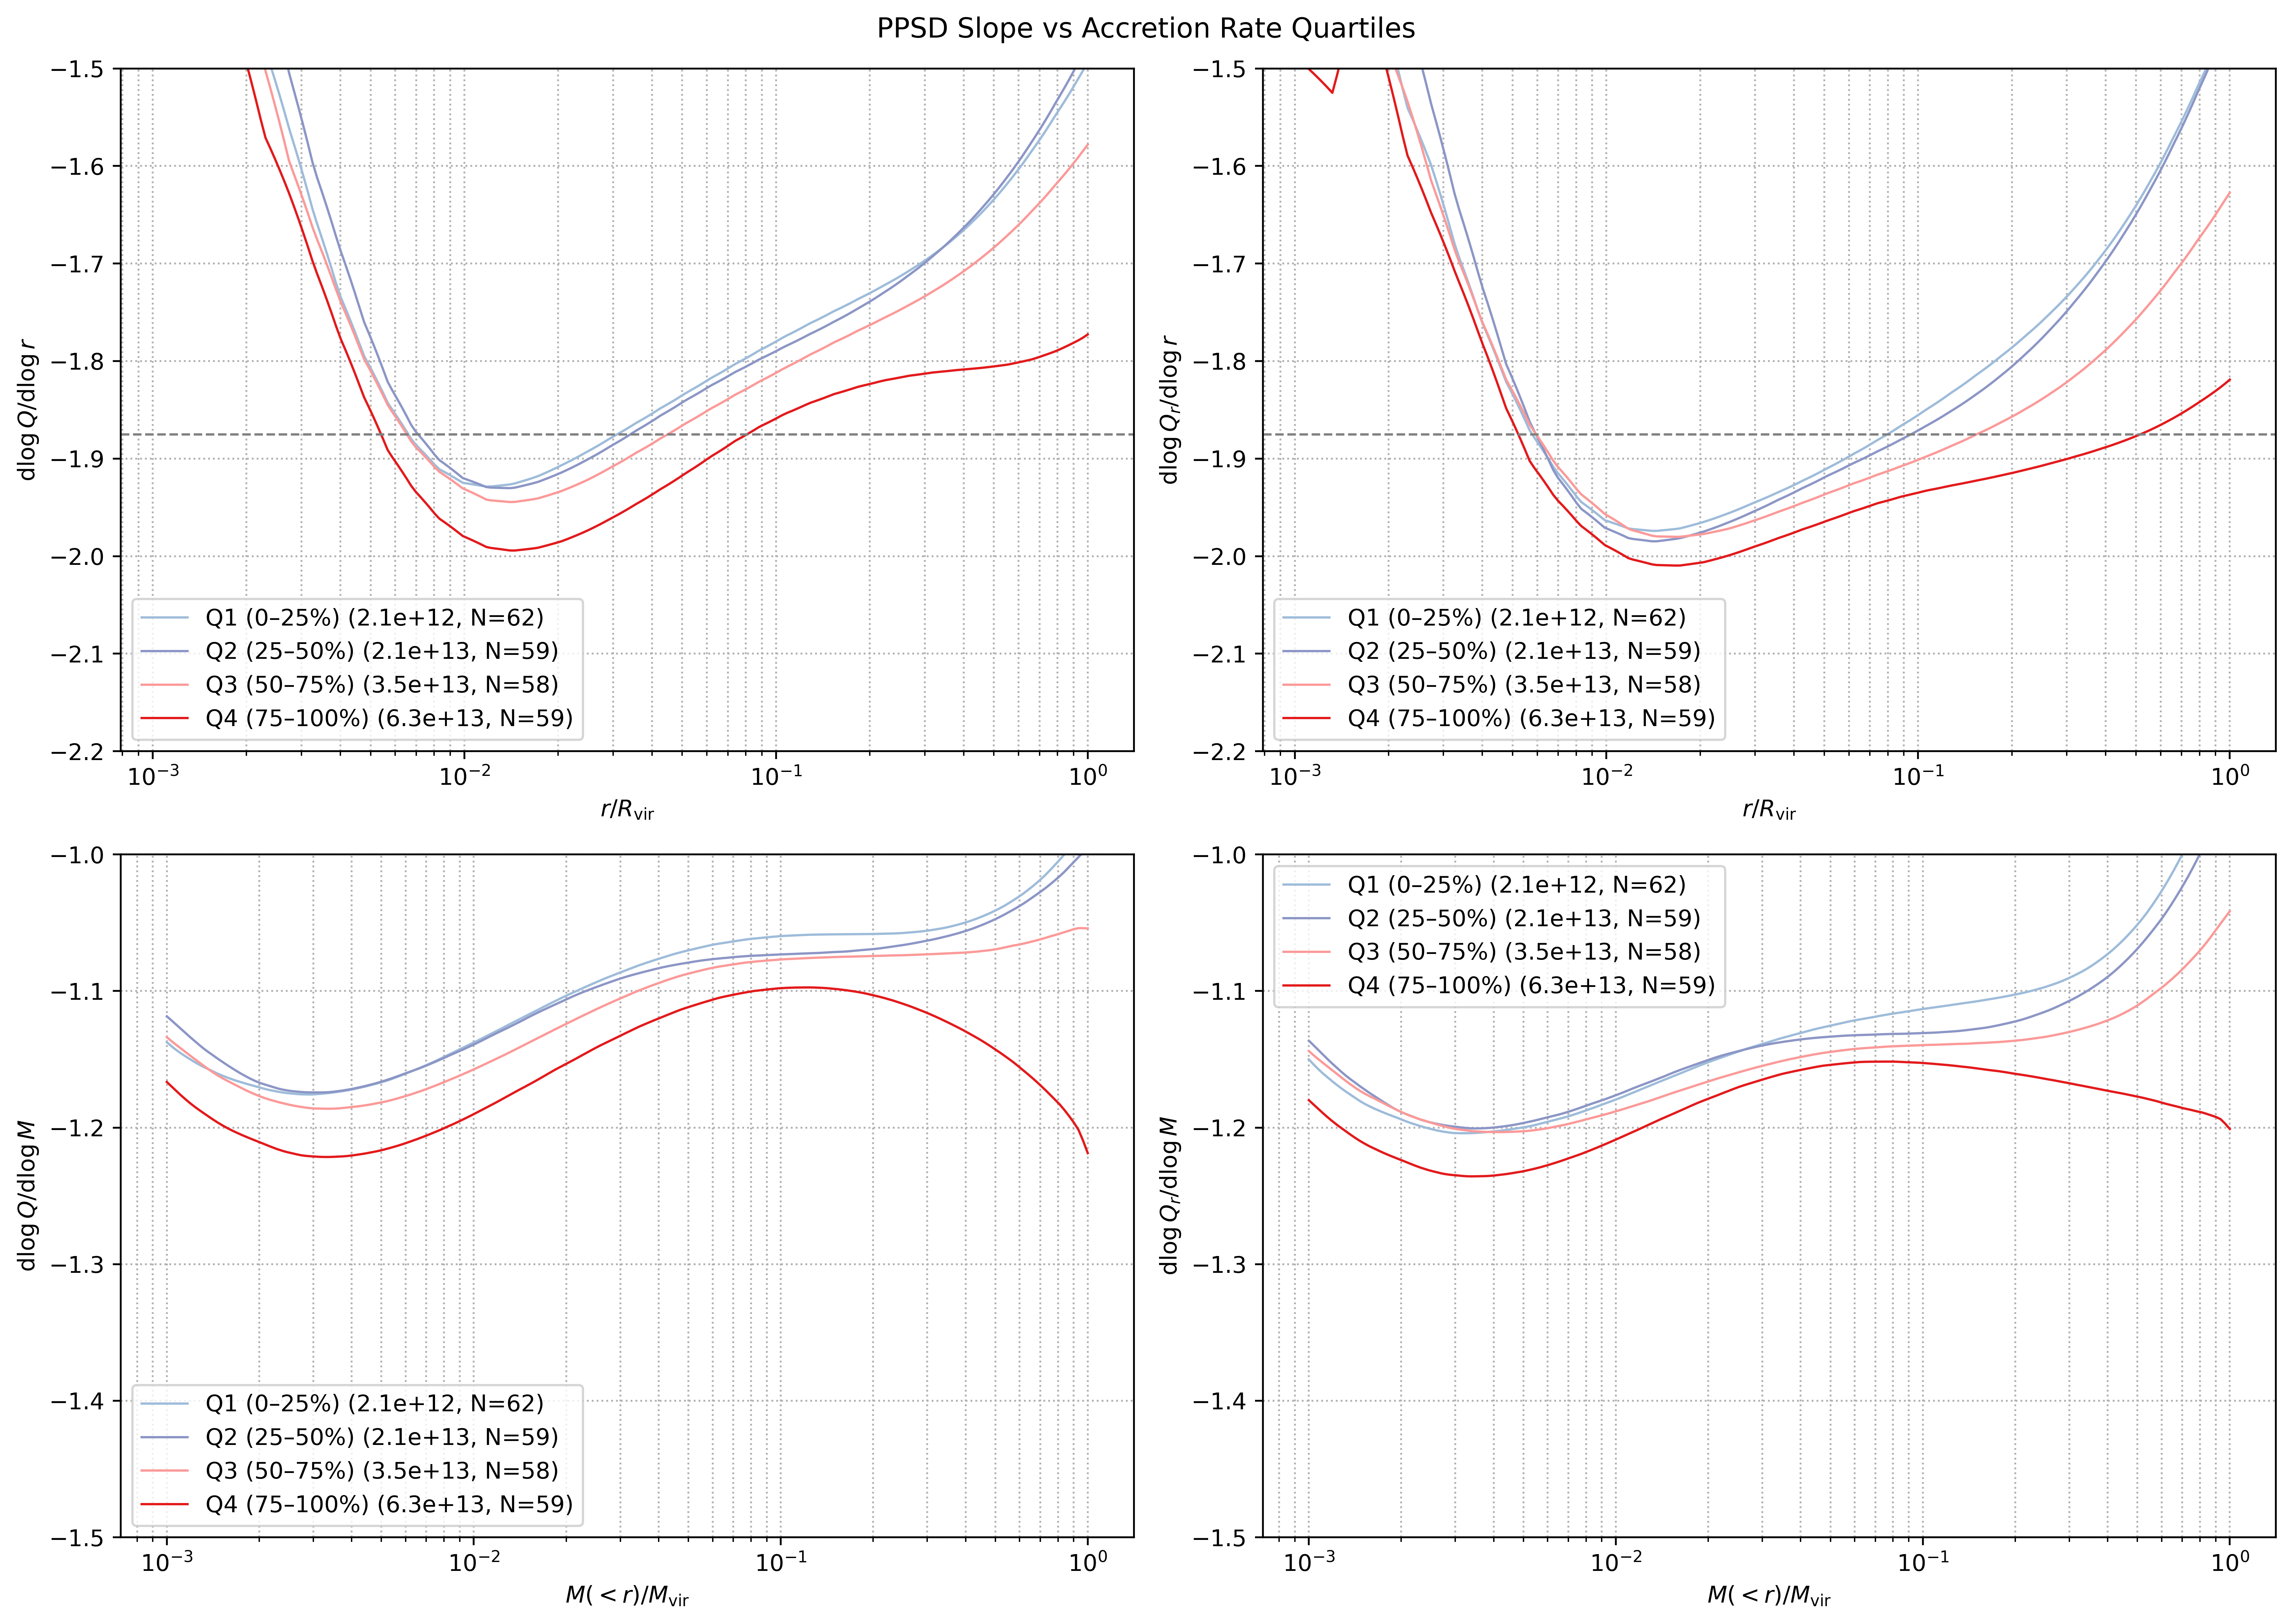

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_ppsd_slope_vs_concentration_and_accretion(base_dir, suite_names):
    def load_slope_data(suite):
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        slope_m_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")

        cvir_df = pd.read_csv(cvir_path)
        gamma_df = pd.read_csv(gamma_path)
        cvir_dict = dict(zip(cvir_df["halo_id"], cvir_df["cvir"]))
        gamma_dict = dict(zip(gamma_df["halo_index"], gamma_df["gamma"]))

        files = sorted([f for f in os.listdir(slope_r_dir) if f.startswith("halo_") and f.endswith(".csv")])
        data = []

        for f in files:
            try:
                halo_id = int(f.split("_")[1])
                dfr = pd.read_csv(os.path.join(slope_r_dir, f))
                dfm = pd.read_csv(os.path.join(slope_m_dir, f))

                r = dfr["r_scaled"].values
                m = dfm["m_scaled"].values
                sr_Qtot = dfr["slope_Q_tot"].values
                sr_Qr = dfr["slope_Q_r"].values
                sm_Qtot = dfm["slope_Q_tot"].values
                sm_Qr = dfm["slope_Q_r"].values

                cvir = cvir_dict.get(halo_id, np.nan)
                gamma = gamma_dict.get(halo_id, np.nan)

                data.append({
                    "halo_id": halo_id,
                    "r": r,
                    "m": m,
                    "sr_Qtot": sr_Qtot,
                    "sr_Qr": sr_Qr,
                    "sm_Qtot": sm_Qtot,
                    "sm_Qr": sm_Qr,
                    "cvir": cvir,
                    "gamma": gamma
                })
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue
        return data

    def group_by_quartiles(data, key):
        values = np.array([d[key] for d in data])
        q25, q50, q75 = np.nanpercentile(values, [25, 50, 75])
        q1 = [d for d in data if d[key] <= q25]
        q2 = [d for d in data if q25 < d[key] <= q50]
        q3 = [d for d in data if q50 < d[key] <= q75]
        q4 = [d for d in data if d[key] > q75]
        return q1, q2, q3, q4

    def interpolate_group(group, key_x, key_y, x_common):
        y_interp = []
        for d in group:
            x, y = d[key_x], d[key_y]
            mask = np.isfinite(x) & np.isfinite(y)
            if np.sum(mask) < 2:
                continue
            try:
                f = interp1d(x[mask], y[mask], bounds_error=False, fill_value=np.nan)
                y_interp.append(f(x_common))
            except:
                continue
        return np.array(y_interp)

    def plot_slope_panels(axs, groups, x_key, y_keys, x_label, use_sci=False):
        x_common = np.logspace(-3, 0, 200) 
        titles = [r"$\mathrm{d}\log Q / \mathrm{d}\log x$", r"$\mathrm{d}\log Q_r / \mathrm{d}\log x$"]
        group_names = ["Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"]
        colors = ["#9ebcda", "#8c96c6", "#fb9a99", "#e31a1c"]

        for i, y_key in enumerate(y_keys):
            for group, name, color in zip(groups, group_names, colors):
                y_interp = interpolate_group(group, x_key, y_key, x_common)
                if len(y_interp) == 0:
                    continue
                y_mean = np.nanmean(y_interp, axis=0)
                y_std = np.nanstd(y_interp, axis=0)

                vals = [d["gamma" if use_sci else "cvir"] for d in group]
                val = np.nanmean(vals)
                fmt_val = f"{val:.1e}" if use_sci else f"{val:.2f}"
                label = f"{name} ({fmt_val}, N={len(group)})"

                axs[i].plot(x_common, y_mean, label=label, color=color, lw=1)
                #axs[i].fill_between(x_common, y_mean - y_std, y_mean + y_std, alpha=0.3, color=color)

            axs[i].set_xscale("log")
            axs[i].set_xlabel(x_label)
            axs[i].set_ylabel(titles[i].replace("x", "r" if x_key == "r" else "M"))
            axs[i].legend()
            axs[i].grid(True, which="both", linestyle=":")

            if x_key == "r":
                axs[i].axhline(-1.875, color="gray", linestyle="--", linewidth=1, label=r"$-1.875$")
                axs[i].set_ylim(-2.2, -1.5)
            else:
                axs[i].set_ylim(-1.5, -1)

    # Quartile group containers
    all_c_q1, all_c_q2, all_c_q3, all_c_q4 = [], [], [], []
    all_g_q1, all_g_q2, all_g_q3, all_g_q4 = [], [], [], []

    for suite in suite_names:
        suite_data = load_slope_data(suite)
        c_q1, c_q2, c_q3, c_q4 = group_by_quartiles(suite_data, "cvir")
        g_q1, g_q2, g_q3, g_q4 = group_by_quartiles(suite_data, "gamma")

        all_c_q1.extend(c_q1)
        all_c_q2.extend(c_q2)
        all_c_q3.extend(c_q3)
        all_c_q4.extend(c_q4)

        all_g_q1.extend(g_q1)
        all_g_q2.extend(g_q2)
        all_g_q3.extend(g_q3)
        all_g_q4.extend(g_q4)

    output_dir = os.path.join(base_dir, "output", "combined")
    os.makedirs(output_dir, exist_ok=True)

    # ---- Concentration Figure ----
    fig_c, axes_c = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    plot_slope_panels(axes_c[0], [all_c_q1, all_c_q2, all_c_q3, all_c_q4], "r", ["sr_Qtot", "sr_Qr"], r"$r / R_{\rm vir}$")
    plot_slope_panels(axes_c[1], [all_c_q1, all_c_q2, all_c_q3, all_c_q4], "m", ["sm_Qtot", "sm_Qr"], r"$M(<r) / M_{\rm vir}$")
    fig_c.suptitle("PPSD Slope vs Concentration Quartiles")
    fig_c.tight_layout()
    fig_c.savefig(os.path.join(output_dir, "ppsd_slope_vs_concentration_quartiles.png"))

    # ---- Accretion Rate Figure ----
    fig_g, axes_g = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    plot_slope_panels(axes_g[0], [all_g_q1, all_g_q2, all_g_q3, all_g_q4], "r", ["sr_Qtot", "sr_Qr"], r"$r / R_{\rm vir}$", use_sci=True)
    plot_slope_panels(axes_g[1], [all_g_q1, all_g_q2, all_g_q3, all_g_q4], "m", ["sm_Qtot", "sm_Qr"], r"$M(<r) / M_{\rm vir}$", use_sci=True)
    fig_g.suptitle("PPSD Slope vs Accretion Rate Quartiles")
    fig_g.tight_layout()
    fig_g.savefig(os.path.join(output_dir, "ppsd_slope_vs_accretion_quartiles.png"))

    plt.show()
    plt.close('all')
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

plot_ppsd_slope_vs_concentration_and_accretion(base_dir, suite_names)

In [11]:
def save_mass(base_dir, suite_name, output):
    output_dir = os.path.join(output, "output", suite_name)
    os.makedirs(output_dir, exist_ok=True)

    n_halos = symlib.n_hosts(suite_name)
    halo_ids, mvir_list = [], []

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)
        try:
            r, _ = symlib.read_rockstar(sim_dir)
            mvir = r[0, -1]["m"] 
            halo_ids.append(f'{halo_idx:03d}')
            mvir_list.append(mvir)
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

    df = pd.DataFrame({"halo_id": halo_ids, "mvir": mvir_list})
    df.to_csv(os.path.join(output_dir, "halo_mass.csv"), index=False)
    print(f"[Saved] Mass CSV to {output_dir}/halo_mass.csv")

#save_mass('/Volumes/Atlas/Symphony', "SymphonyLMC",  "/Users/fengbocheng/Projects/Symphony-PPSD")
#save_mass('/Volumes/Atlas/Symphony', "SymphonyMilkyWay",  "/Users/fengbocheng/Projects/Symphony-PPSD")
#save_mass('/Volumes/Expansion/Symphony', "SymphonyGroup",  "/Users/fengbocheng/Projects/Symphony-PPSD")
#save_mass('/Volumes/Atlas/Symphony', "SymphonyLCluster",  "/Users/fengbocheng/Projects/Symphony-PPSD")
save_mass('/Volumes/Expansion/Symphony', "SymphonyCluster",  "/Users/fengbocheng/Projects/Symphony-PPSD")

[Saved] Mass CSV to /Users/fengbocheng/Projects/Symphony-PPSD/output/SymphonyCluster/halo_mass.csv


Spearman ρ = -0.276, p = 4.01e-05


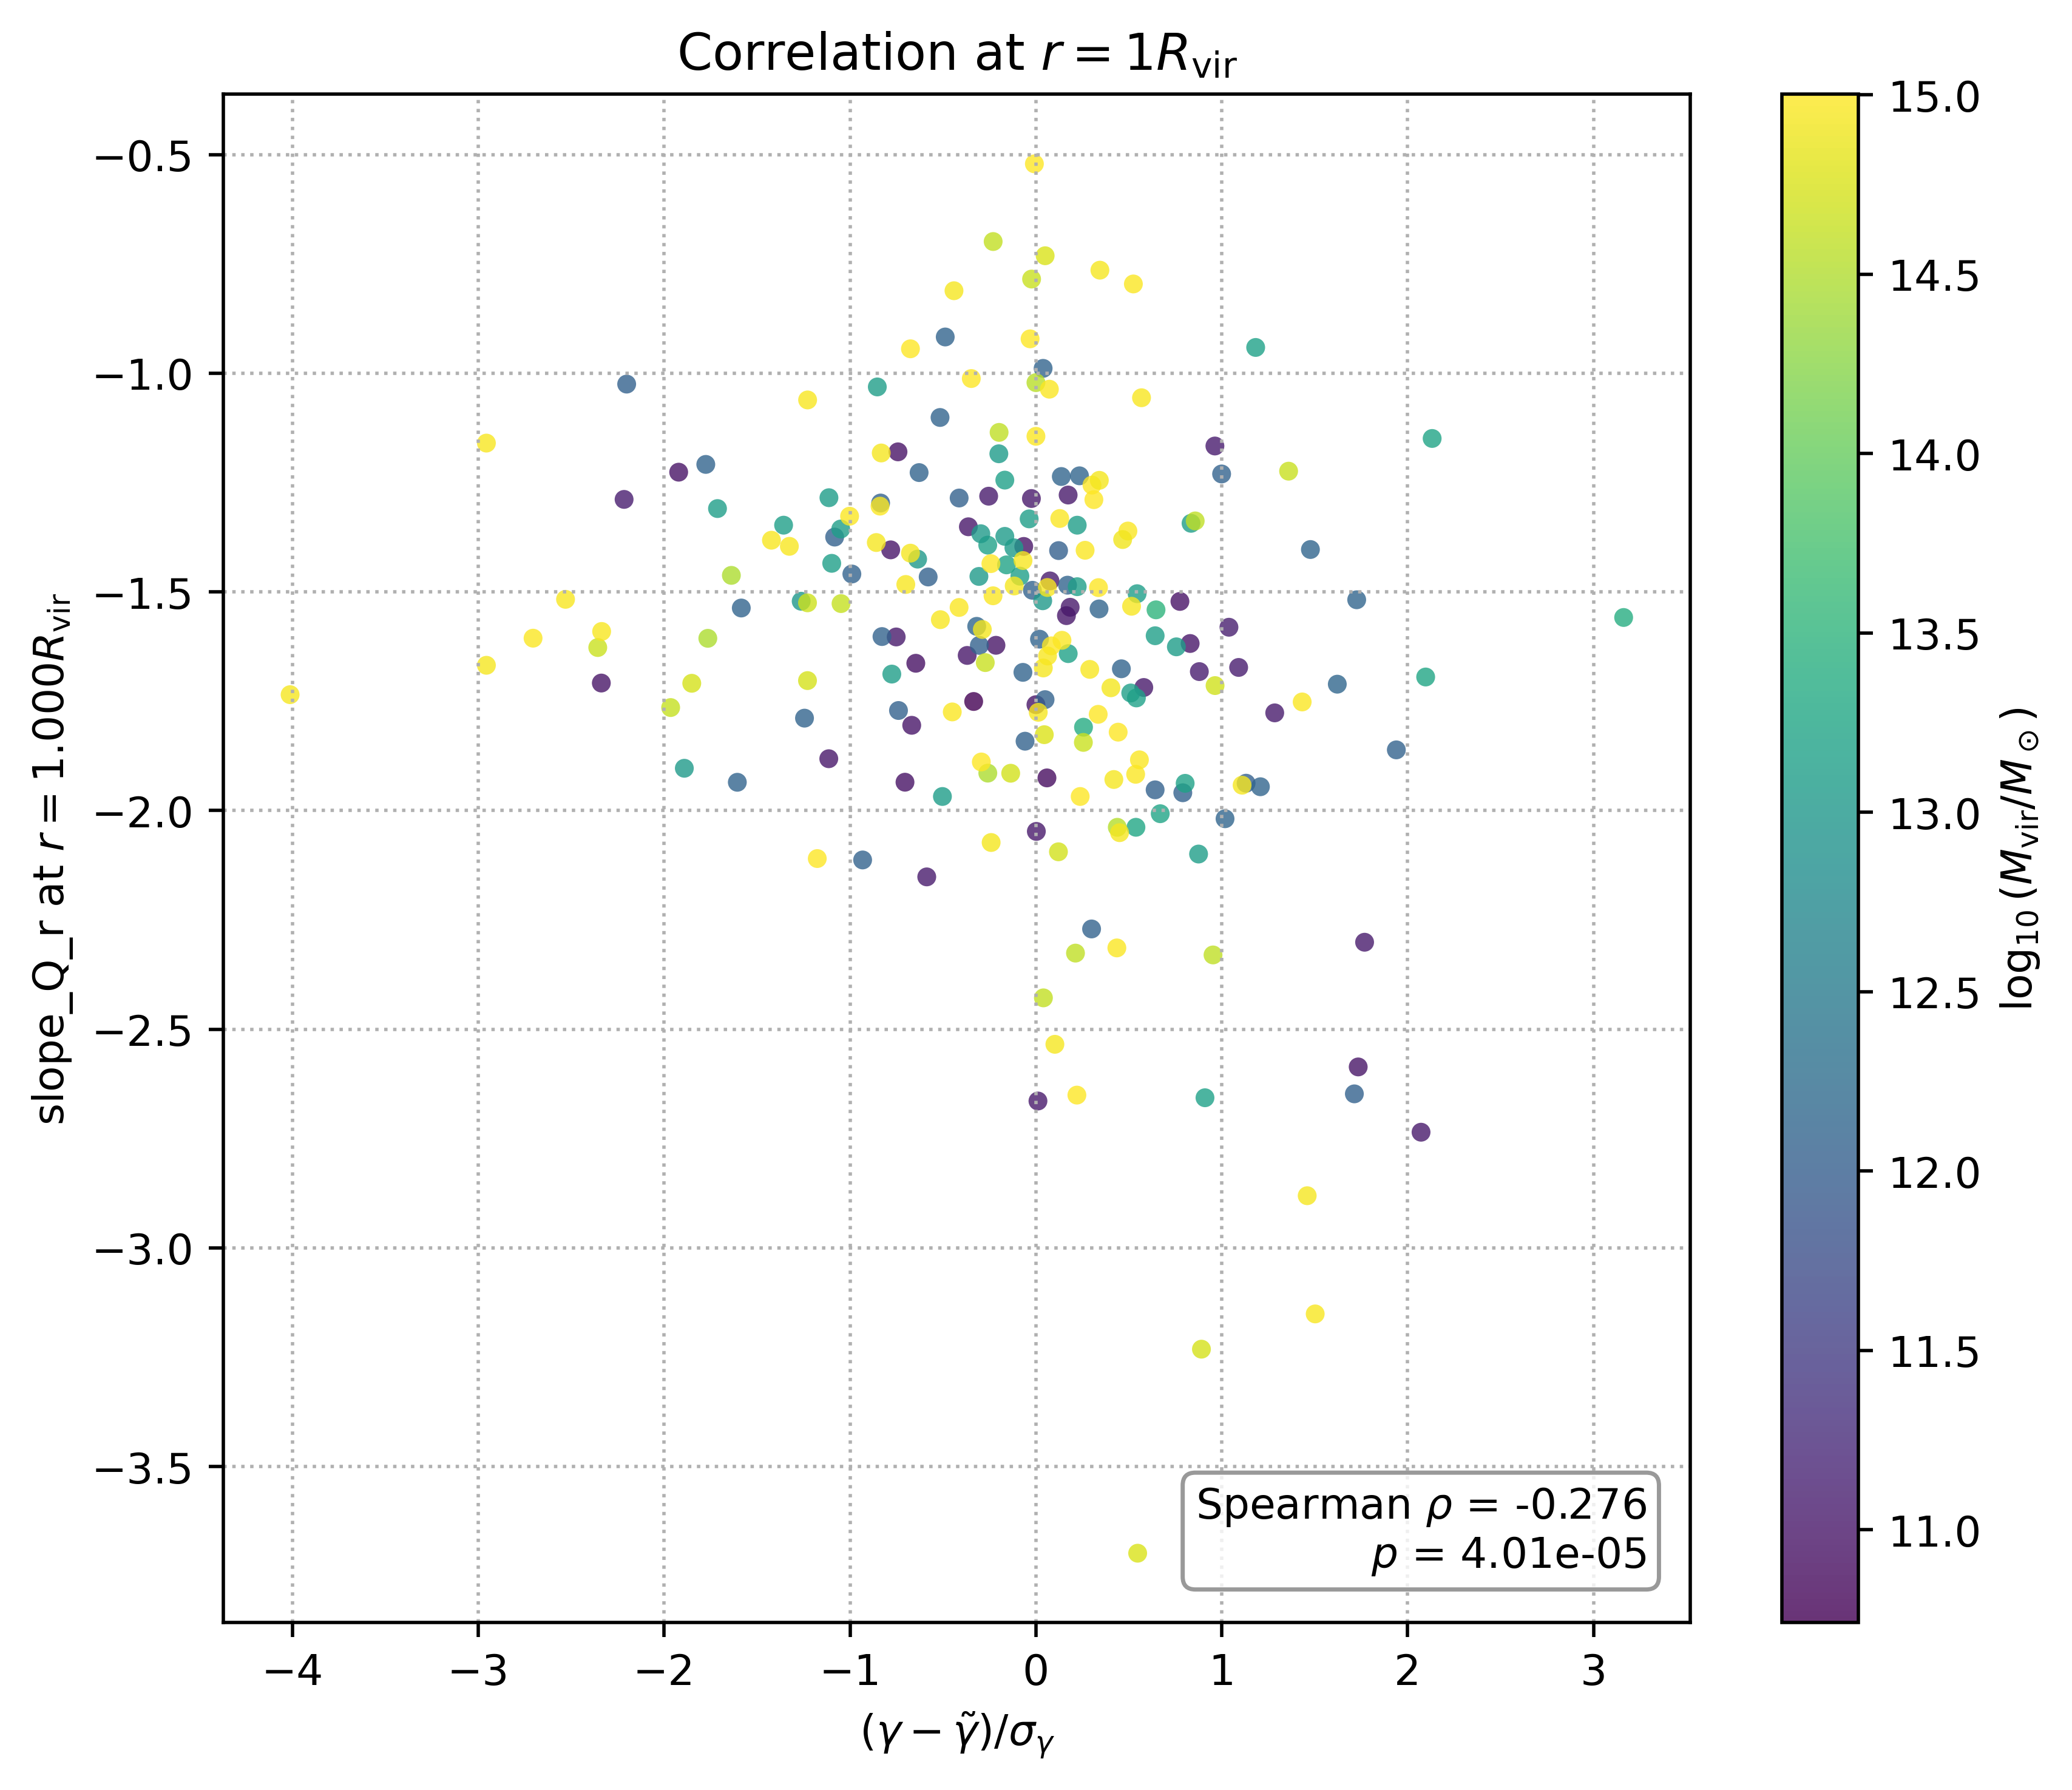

Spearman ρ = 0.349, p = 3.74e-08


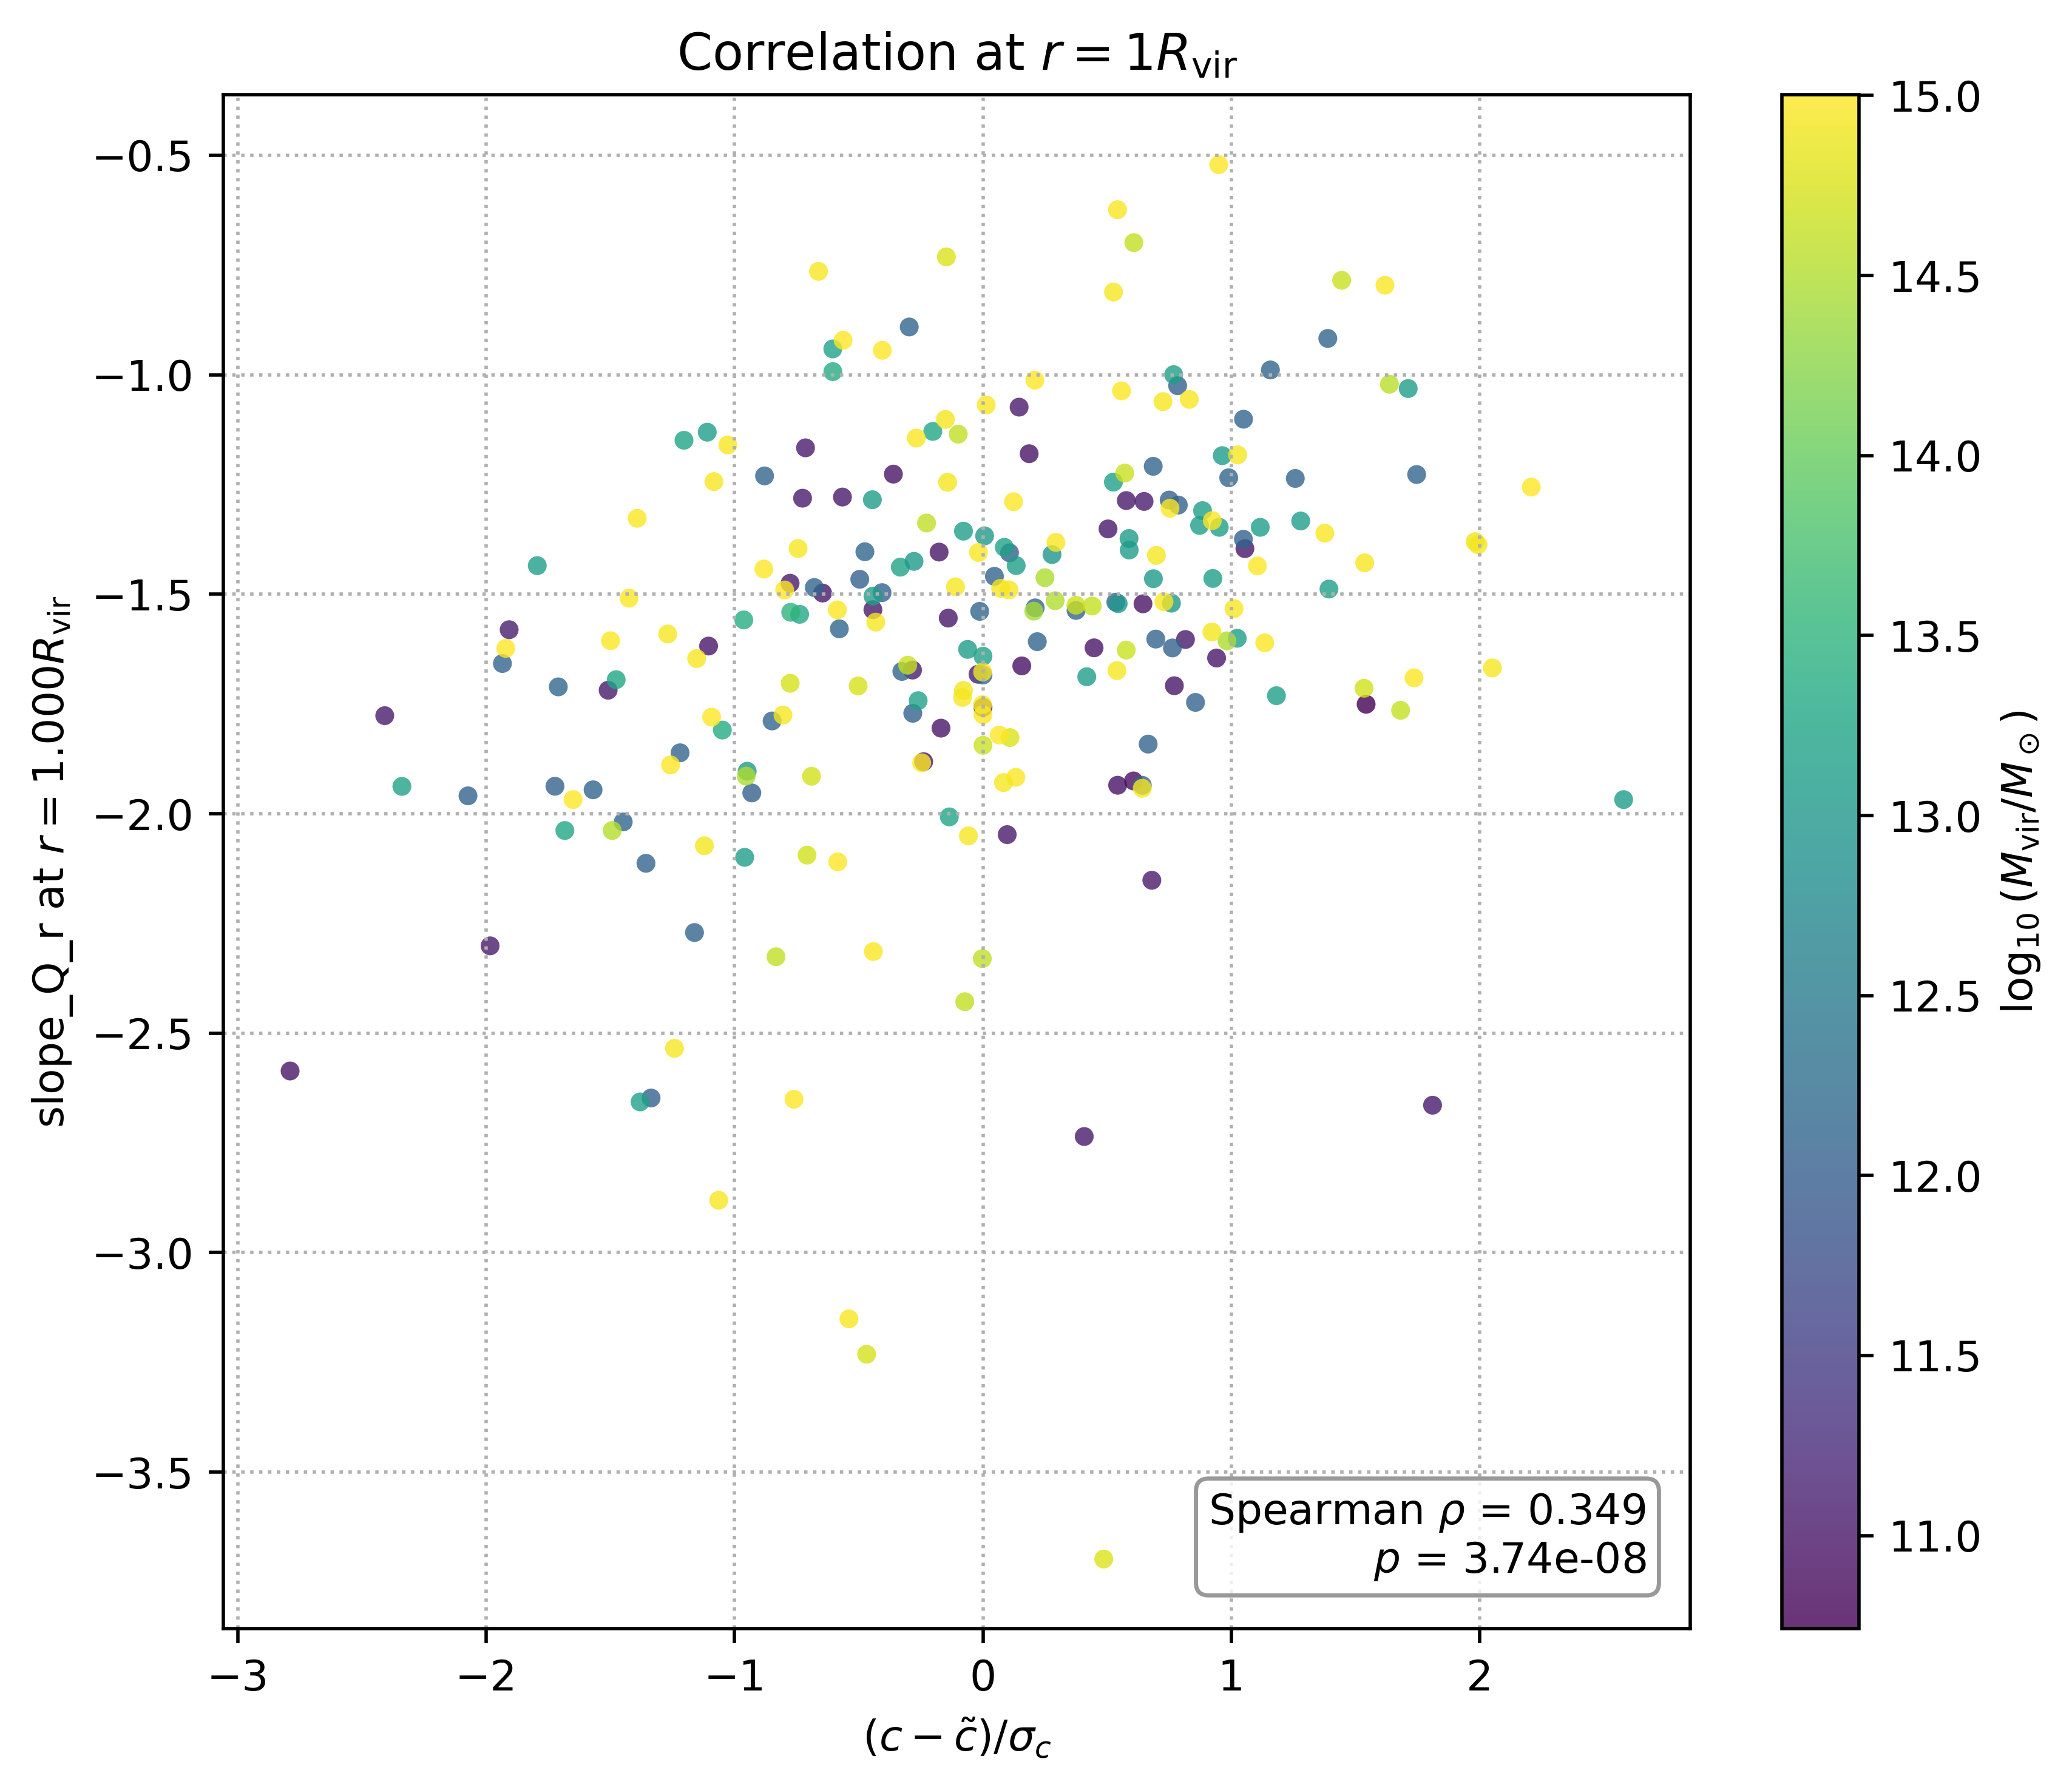

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def quantify_correlation(base_dir, suite_names, r_target=0.01, x_var="cvir", slope_var="slope_Q_r"):
    slope_vals, x_vals, mass_vals = [], [], []

    for suite in suite_names:
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        cvir_dict = dict(zip(df_cvir["halo_id"], df_cvir["cvir"]))
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))
        mass_dict = dict(zip(pd.read_csv(mass_path)["halo_id"], pd.read_csv(mass_path)["mvir"]))

        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med = np.nanmedian(c_vals)
            c_std = np.nanstd(c_vals)
            delta_c_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            valid_gamma = df_gamma["gamma"].values
            valid_mask = (valid_gamma > 0) & np.isfinite(valid_gamma)
            log_g_vals = np.log10(valid_gamma[valid_mask])

            log_g_med = np.nanmedian(log_g_vals)
            log_g_std = np.nanstd(log_g_vals)

            delta_g_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - log_g_med) / log_g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        for f in sorted([f for f in os.listdir(slope_r_dir) if f.endswith(".csv")]):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(slope_r_dir, f))
                r = df["r_scaled"].values
                slope = df[slope_var].values
                interp_func = interp1d(r, slope, bounds_error=False, fill_value=np.nan)
                slope_val = float(interp_func(r_target))

                if x_var == "cvir":
                    x = cvir_dict.get(halo_id)
                elif x_var == "gamma":
                    x = gamma_dict.get(halo_id)
                elif x_var == "delta_c_norm":
                    x = delta_c_dict.get(halo_id)
                elif x_var == "delta_gamma_norm":
                    x = delta_g_dict.get(halo_id)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(halo_id, np.nan)
                try:
                    slope_val = float(interp_func(r_target))
                    x = float(x) 
                    mass = float(mass)
                except Exception as e:
                    continue
                if np.isfinite(slope_val) and np.isfinite(x) and (x_var != "gamma" or x > 0):
                    slope_vals.append(slope_val)
                    x_vals.append(x)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    slope_vals = np.array(slope_vals)
    x_vals = np.array(x_vals)
    mass_vals = np.array(mass_vals)

    if len(slope_vals) < 2:
        print("[Warning] Not enough valid data to compute correlation.")
        return

    log_mass = np.log10(mass_vals)
    log_x = np.log10(x_vals) if x_var == "gamma" else x_vals

    spearman_r, spearman_p = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors='none')
    cbar = plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")

    xlabel_map = {
        "cvir": r"$c_{\rm vir}$",
        "gamma": r"$\log_{10}(\gamma)$",
        "delta_c_norm": r"$(c - \tilde{c}) / \sigma_c$",
        "delta_gamma_norm": r"$(\gamma - \tilde{\gamma}) / \sigma_\gamma$"
    }
    plt.xlabel(xlabel_map.get(x_var, x_var))
    plt.ylabel(fr"{slope_var} at $r = {r_target:.3f} R_{{\rm vir}}$")
    plt.title(f"Correlation at $r = {r_target} R_{{\\rm vir}}$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()
    
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
quantify_correlation(
    base_dir, suite_names,
    r_target=1,
    x_var="delta_gamma_norm",
    slope_var="slope_Q_r"
)

quantify_correlation(
    base_dir, suite_names,
    r_target=1,
    x_var="delta_c_norm",
    slope_var="slope_Q_r"
)


Spearman ρ = 0.251, p = 8.83e-05


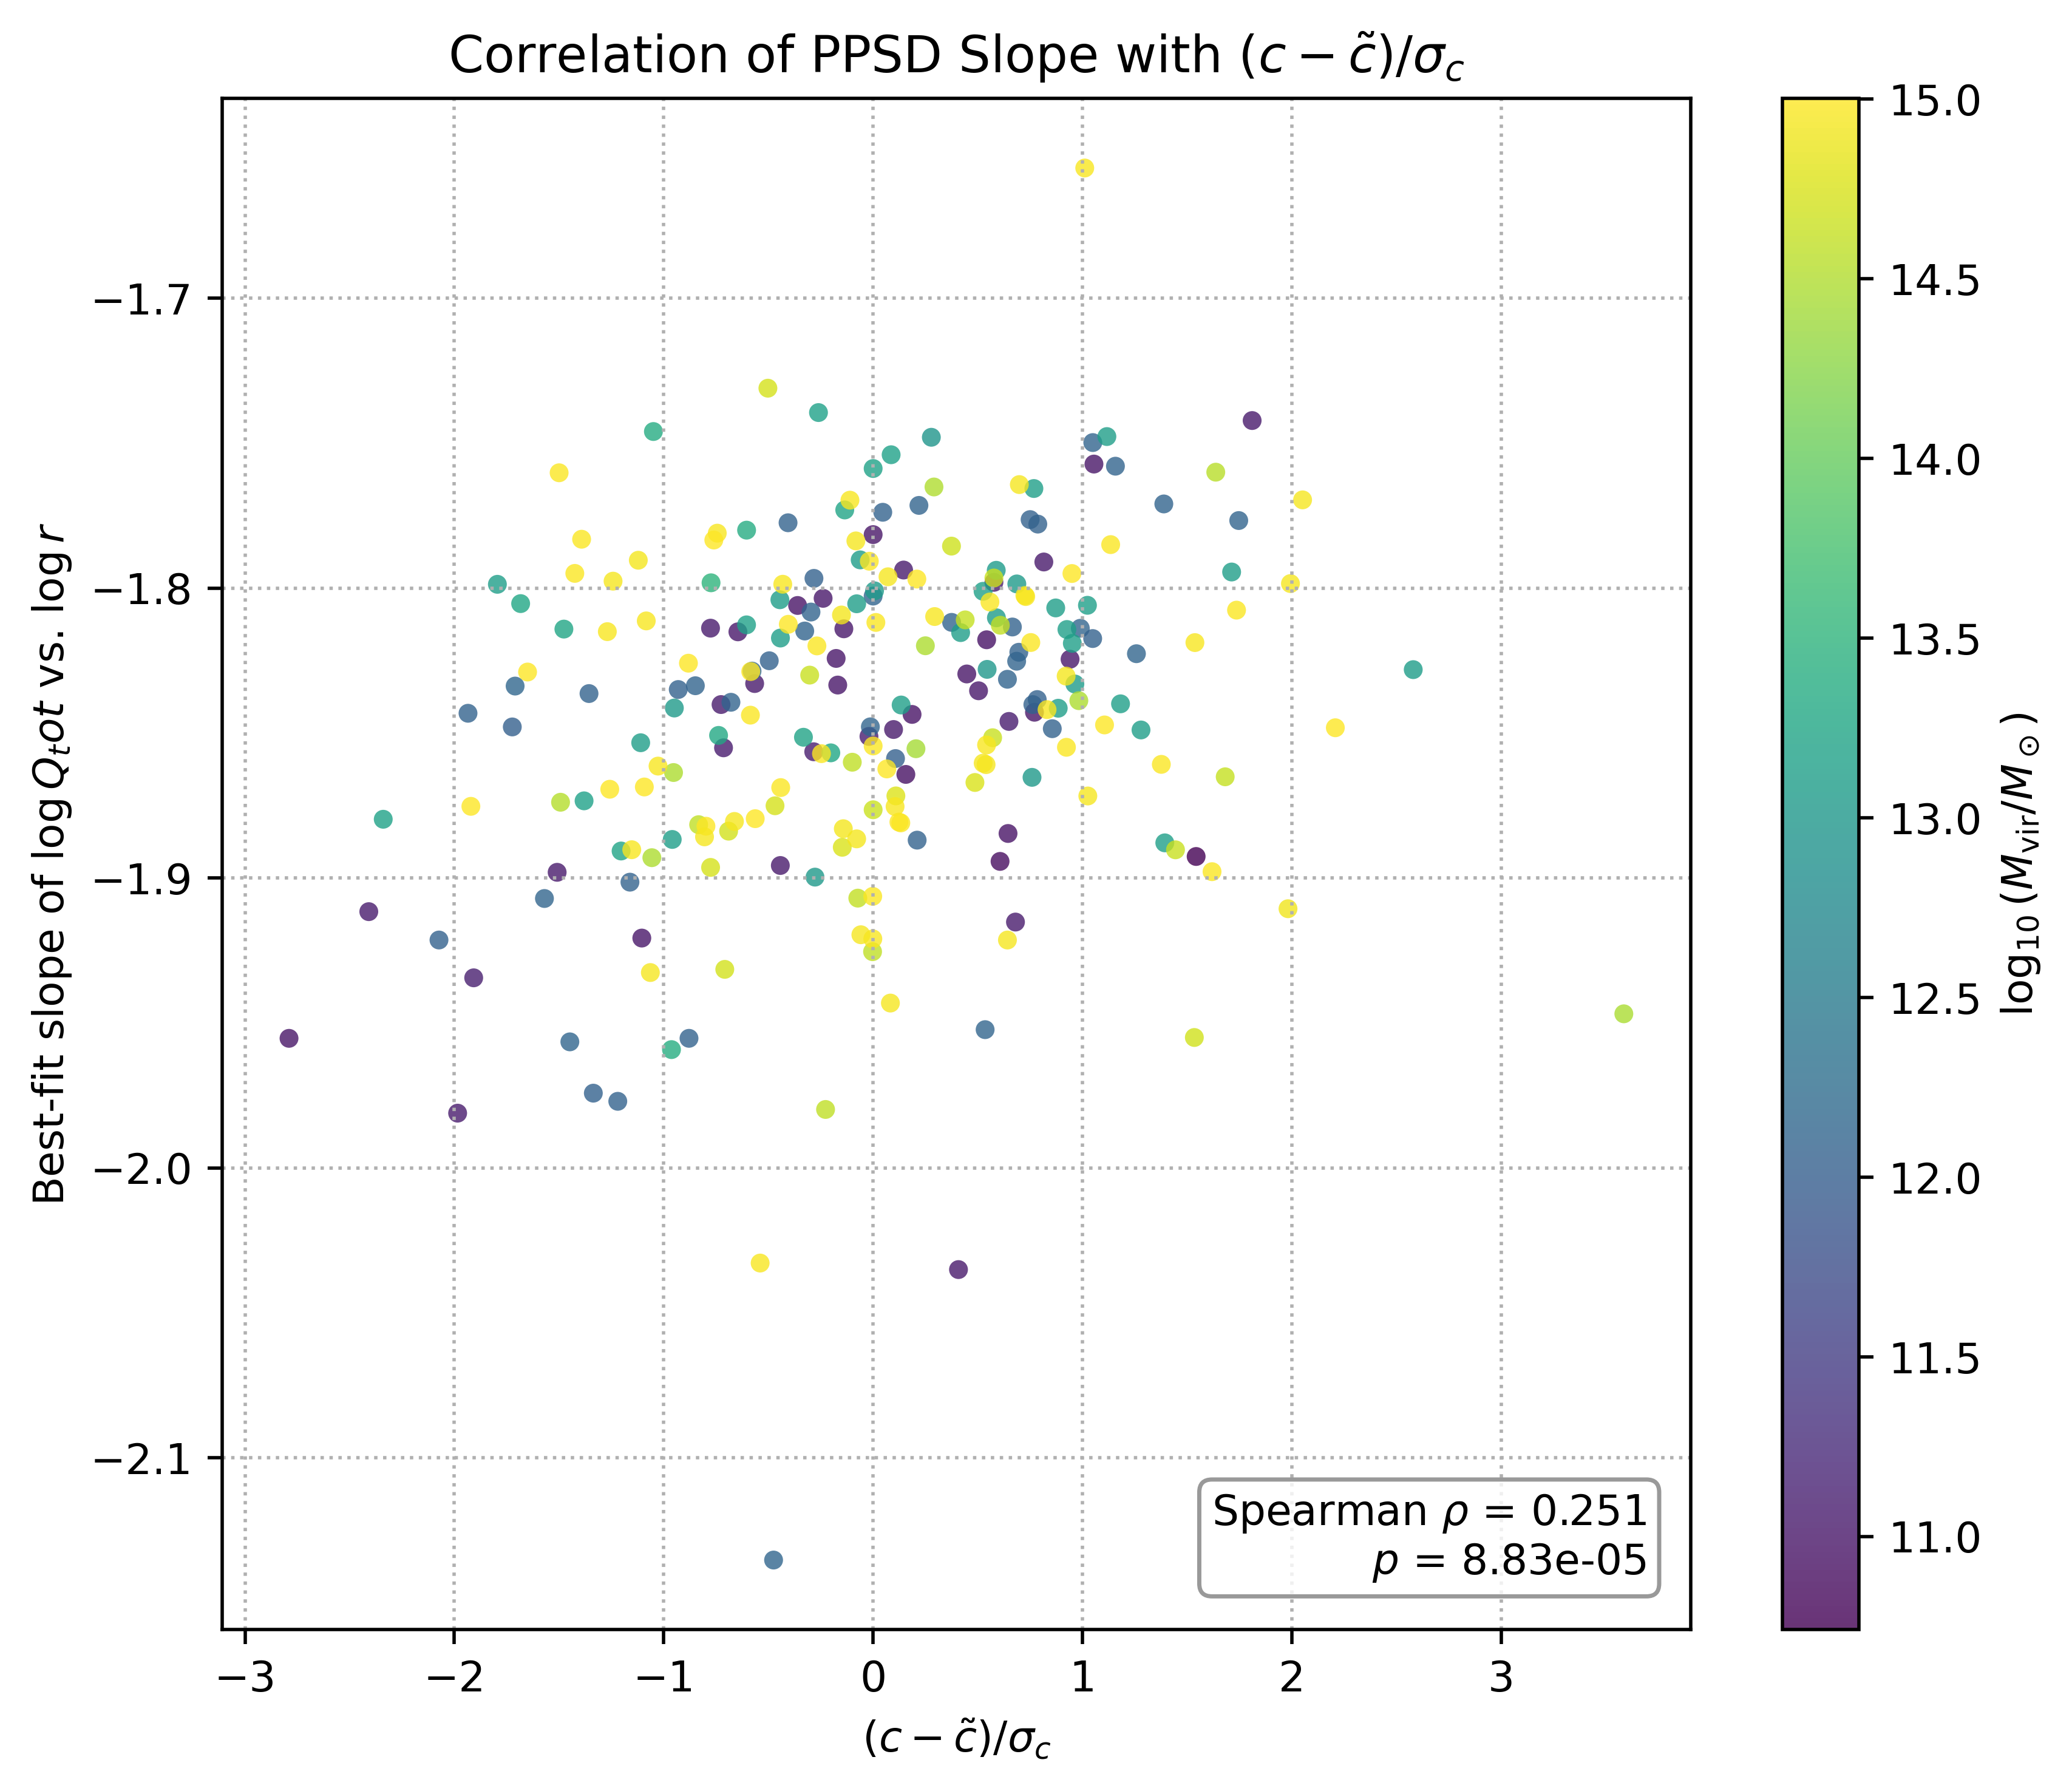

[Warning] Failed to process halo_010_profile.csv in SymphonyLMC: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
[Warning] Failed to process halo_016_profile.csv in SymphonyLMC: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
[Warning] Failed to process halo_002_profile.csv in SymphonyMilkyWay: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
[Warning] Failed to process halo_022_profile.csv in SymphonyMilkyWay: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
[Warning] Failed to process halo_041_profile.csv in SymphonyMilkyWay: ufunc 'isfinite' not supported f

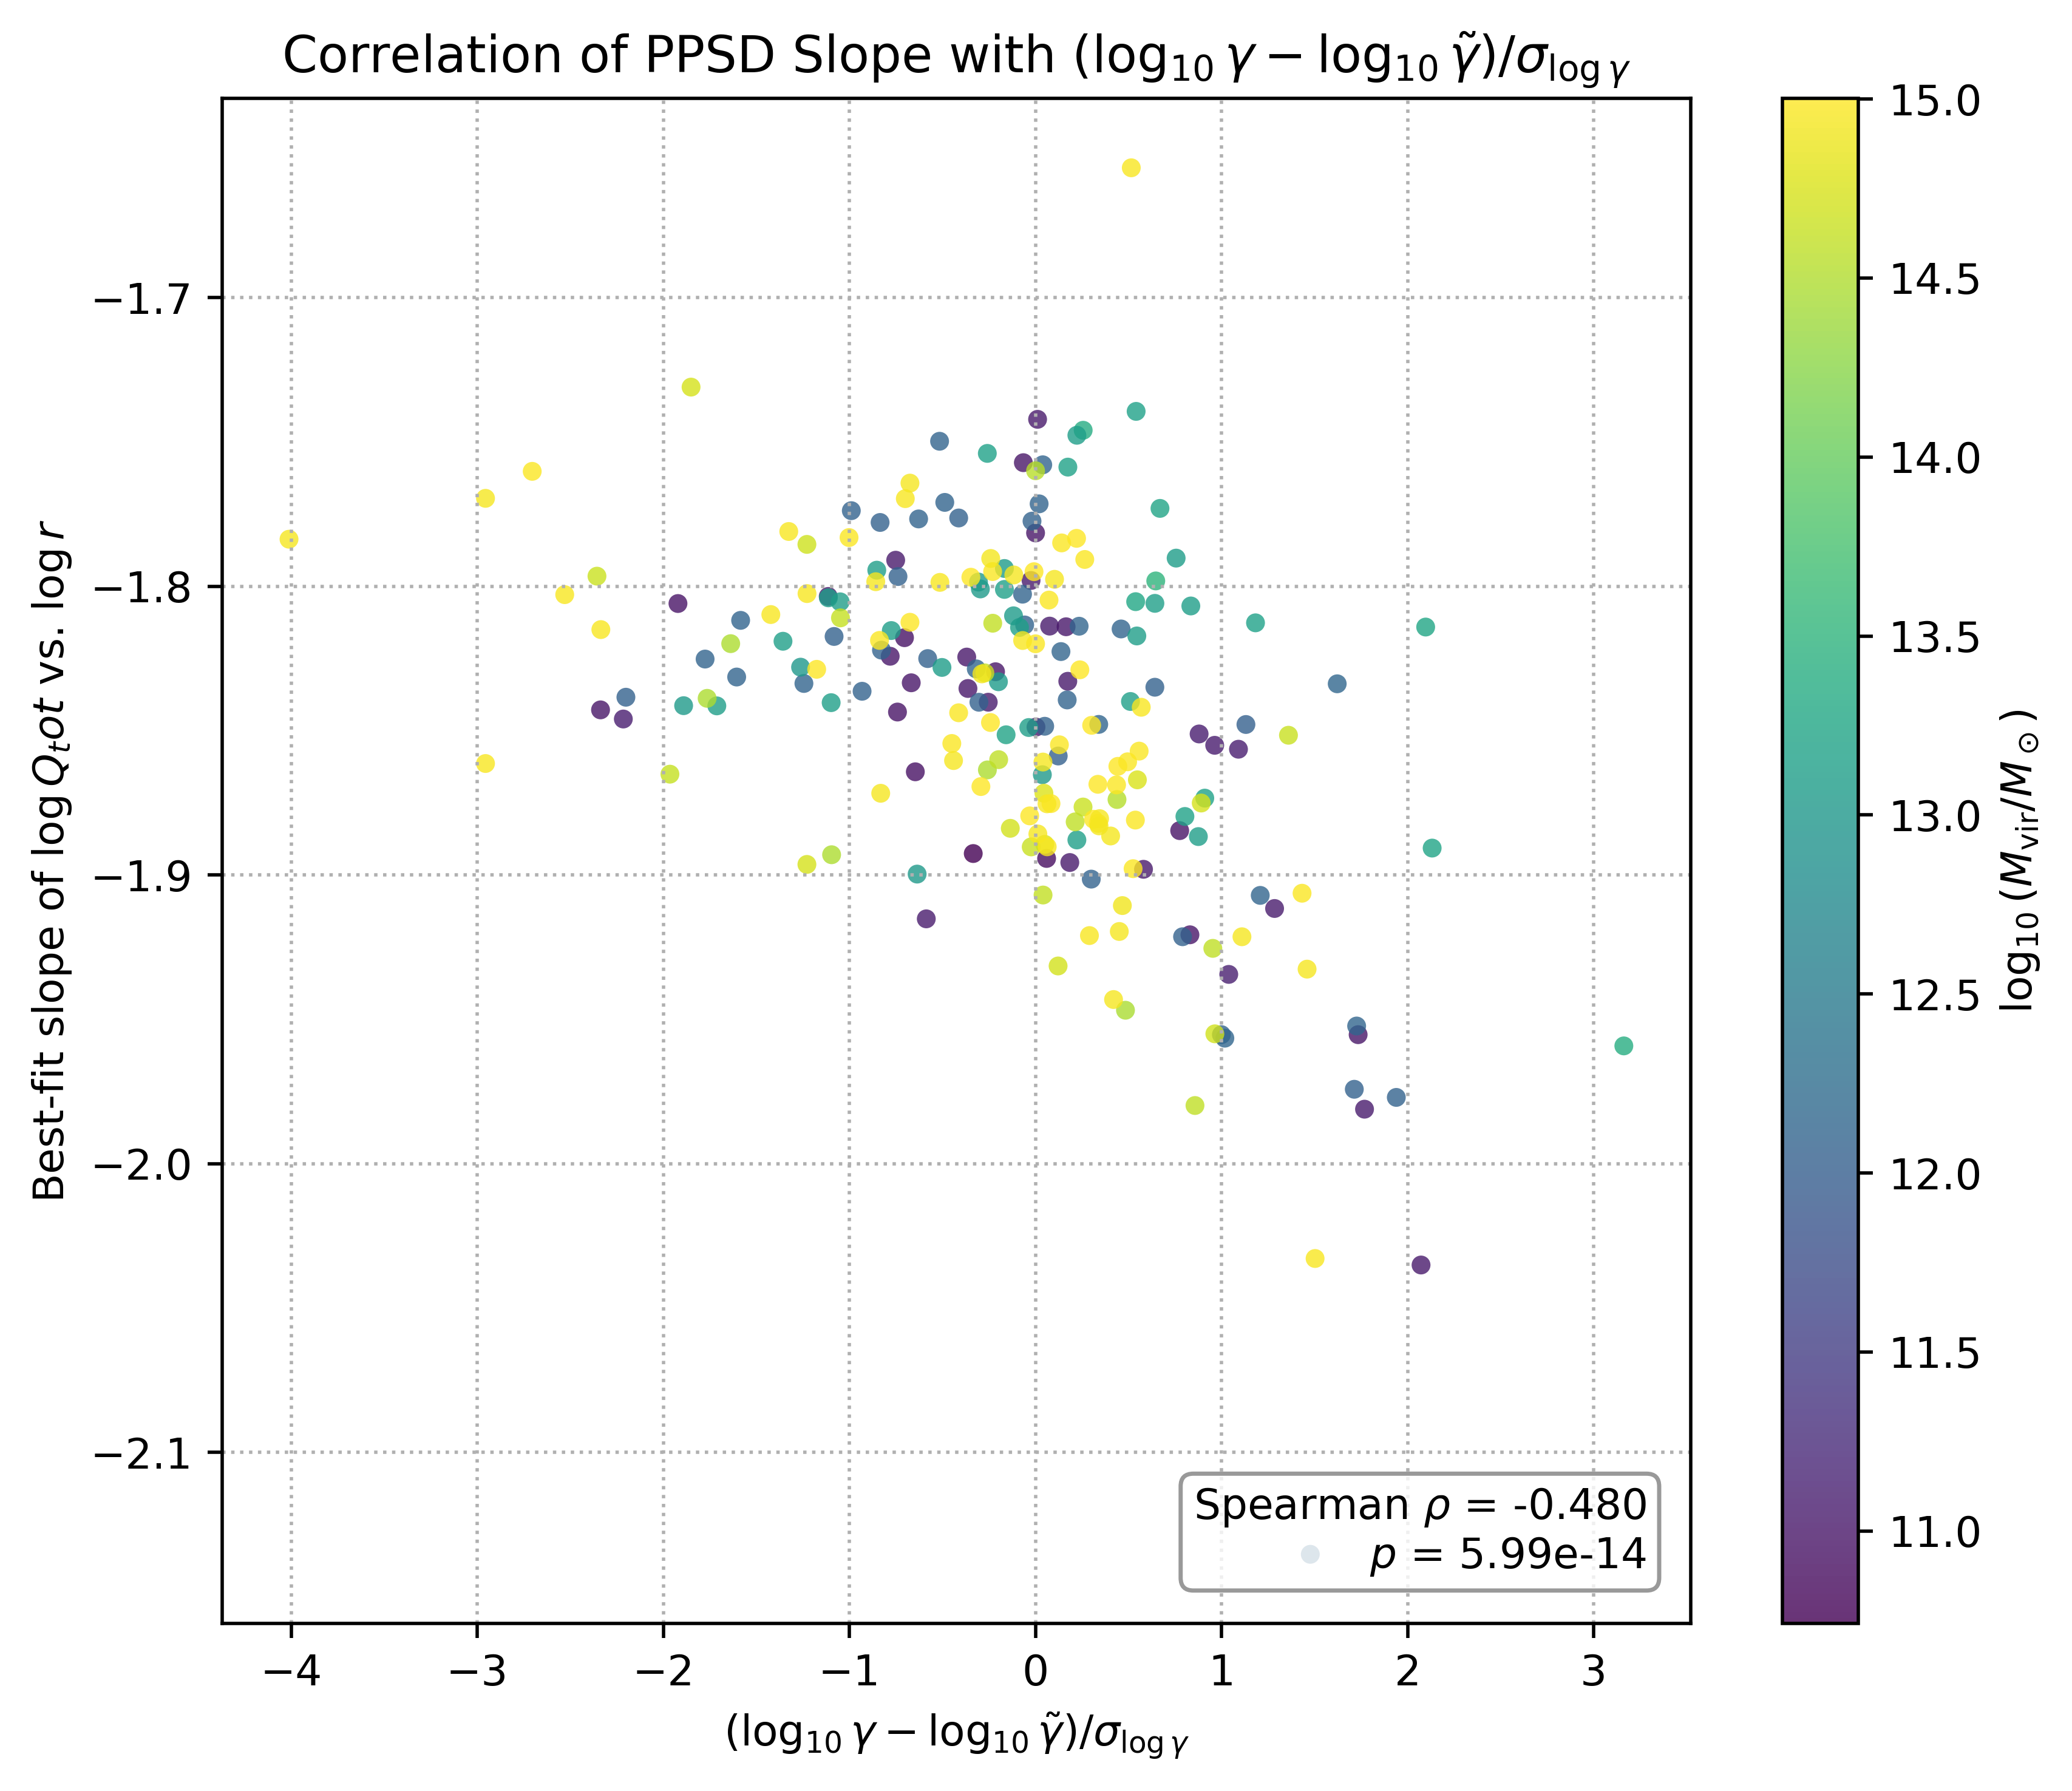

In [7]:
from scipy.stats import spearmanr
from scipy.optimize import curve_fit

def fit_loglog_powerlaw(x, y):
    valid = np.isfinite(x) & np.isfinite(y)
    if np.sum(valid) < 5:
        return np.nan
    A = np.vstack([x[valid], np.ones_like(x[valid])]).T
    slope, intercept = np.linalg.lstsq(A, y[valid], rcond=None)[0]
    return slope

def quantify_bestfit_slope_vs_cgamma(base_dir, suite_names, x_var="cvir", quantity="Q_r", fit_range=(0.01, 1.0)):
    slope_vals, x_vals, mass_vals = [], [], []

    for suite in suite_names:
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        df_mass = pd.read_csv(mass_path)

        cvir_dict = dict(zip(df_cvir["halo_id"], pd.to_numeric(df_cvir["cvir"], errors='coerce')))
        gamma_dict = dict(zip(df_gamma["halo_index"], pd.to_numeric(df_gamma["gamma"], errors='coerce')))
        mass_dict = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))
        
        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_mean = np.nanmean(c_vals)
            c_med = np.nanmedian(c_vals)
            c_std = np.nanstd(c_vals)
            delta_c_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            valid_gamma = df_gamma["gamma"].values
            valid_mask = (valid_gamma > 0) & np.isfinite(valid_gamma)
            log_g_vals = np.log10(valid_gamma[valid_mask])
            log_g_mean = np.nanmean(log_g_vals)
            log_g_med = np.nanmedian(log_g_vals)
            log_g_std = np.nanstd(log_g_vals)
            delta_g_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - log_g_med) / log_g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        for f in sorted(os.listdir(profile_dir)):
            if not f.endswith(".csv"):
                continue
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(profile_dir, f))
                Q = pd.to_numeric(df[quantity], errors='coerce').values
                r = pd.to_numeric(df["r_scaled"], errors='coerce').values

                valid = (r >= fit_range[0]) & (r <= fit_range[1]) & np.isfinite(Q) & (Q > 0)
                if np.sum(valid) < 5:
                    continue

                log_r = np.log10(r[valid])
                log_Q = np.log10(Q[valid])
                slope = fit_loglog_powerlaw(log_r, log_Q)

                if x_var == "cvir":
                    x = cvir_dict.get(halo_id)
                elif x_var == "gamma":
                    x = gamma_dict.get(halo_id)
                elif x_var == "delta_c_norm":
                    x = delta_c_dict.get(halo_id)
                elif x_var == "delta_gamma_norm":
                    x = delta_g_dict.get(halo_id)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(halo_id, np.nan)

                if np.isfinite(slope) and np.isfinite(x) and (x_var != "gamma" or x > 0):
                    slope_vals.append(slope)
                    x_vals.append(x)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    slope_vals = np.array(slope_vals)
    x_vals = np.array(x_vals)
    mass_vals = np.array(mass_vals)

    if len(slope_vals) < 2:
        print("[Warning] Not enough valid data to compute correlation.")
        return

    log_mass = np.log10(mass_vals)
    log_x = np.log10(x_vals) if x_var == "gamma" else x_vals

    spearman_r, spearman_p = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors='none')
    plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")

    xlabel_map = {
        "cvir": r"$c_{\rm vir}$",
        "gamma": r"$\log_{10}(\gamma)$",
        "delta_c_norm": r"$(c - \tilde{c}) / \sigma_c$",
        "delta_gamma_norm": r"$(\log_{10} \gamma - \log_{10} \tilde{\gamma}) / \sigma_{\log \gamma}$"
    }
    plt.xlabel(xlabel_map.get(x_var, x_var))
    plt.ylabel(rf"Best-fit slope of $\log {quantity}$ vs. $\log r$")
    plt.title("Correlation of PPSD Slope with " + xlabel_map.get(x_var, x_var))
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

quantify_bestfit_slope_vs_cgamma(
    base_dir, suite_names,
    x_var="delta_c_norm",
    quantity="Q_tot",
    fit_range=(0.01, 1.0)
)

quantify_bestfit_slope_vs_cgamma(
    base_dir, suite_names,
    x_var="delta_gamma_norm",
    quantity="Q_tot",
    fit_range=(0.01, 1.0)
)

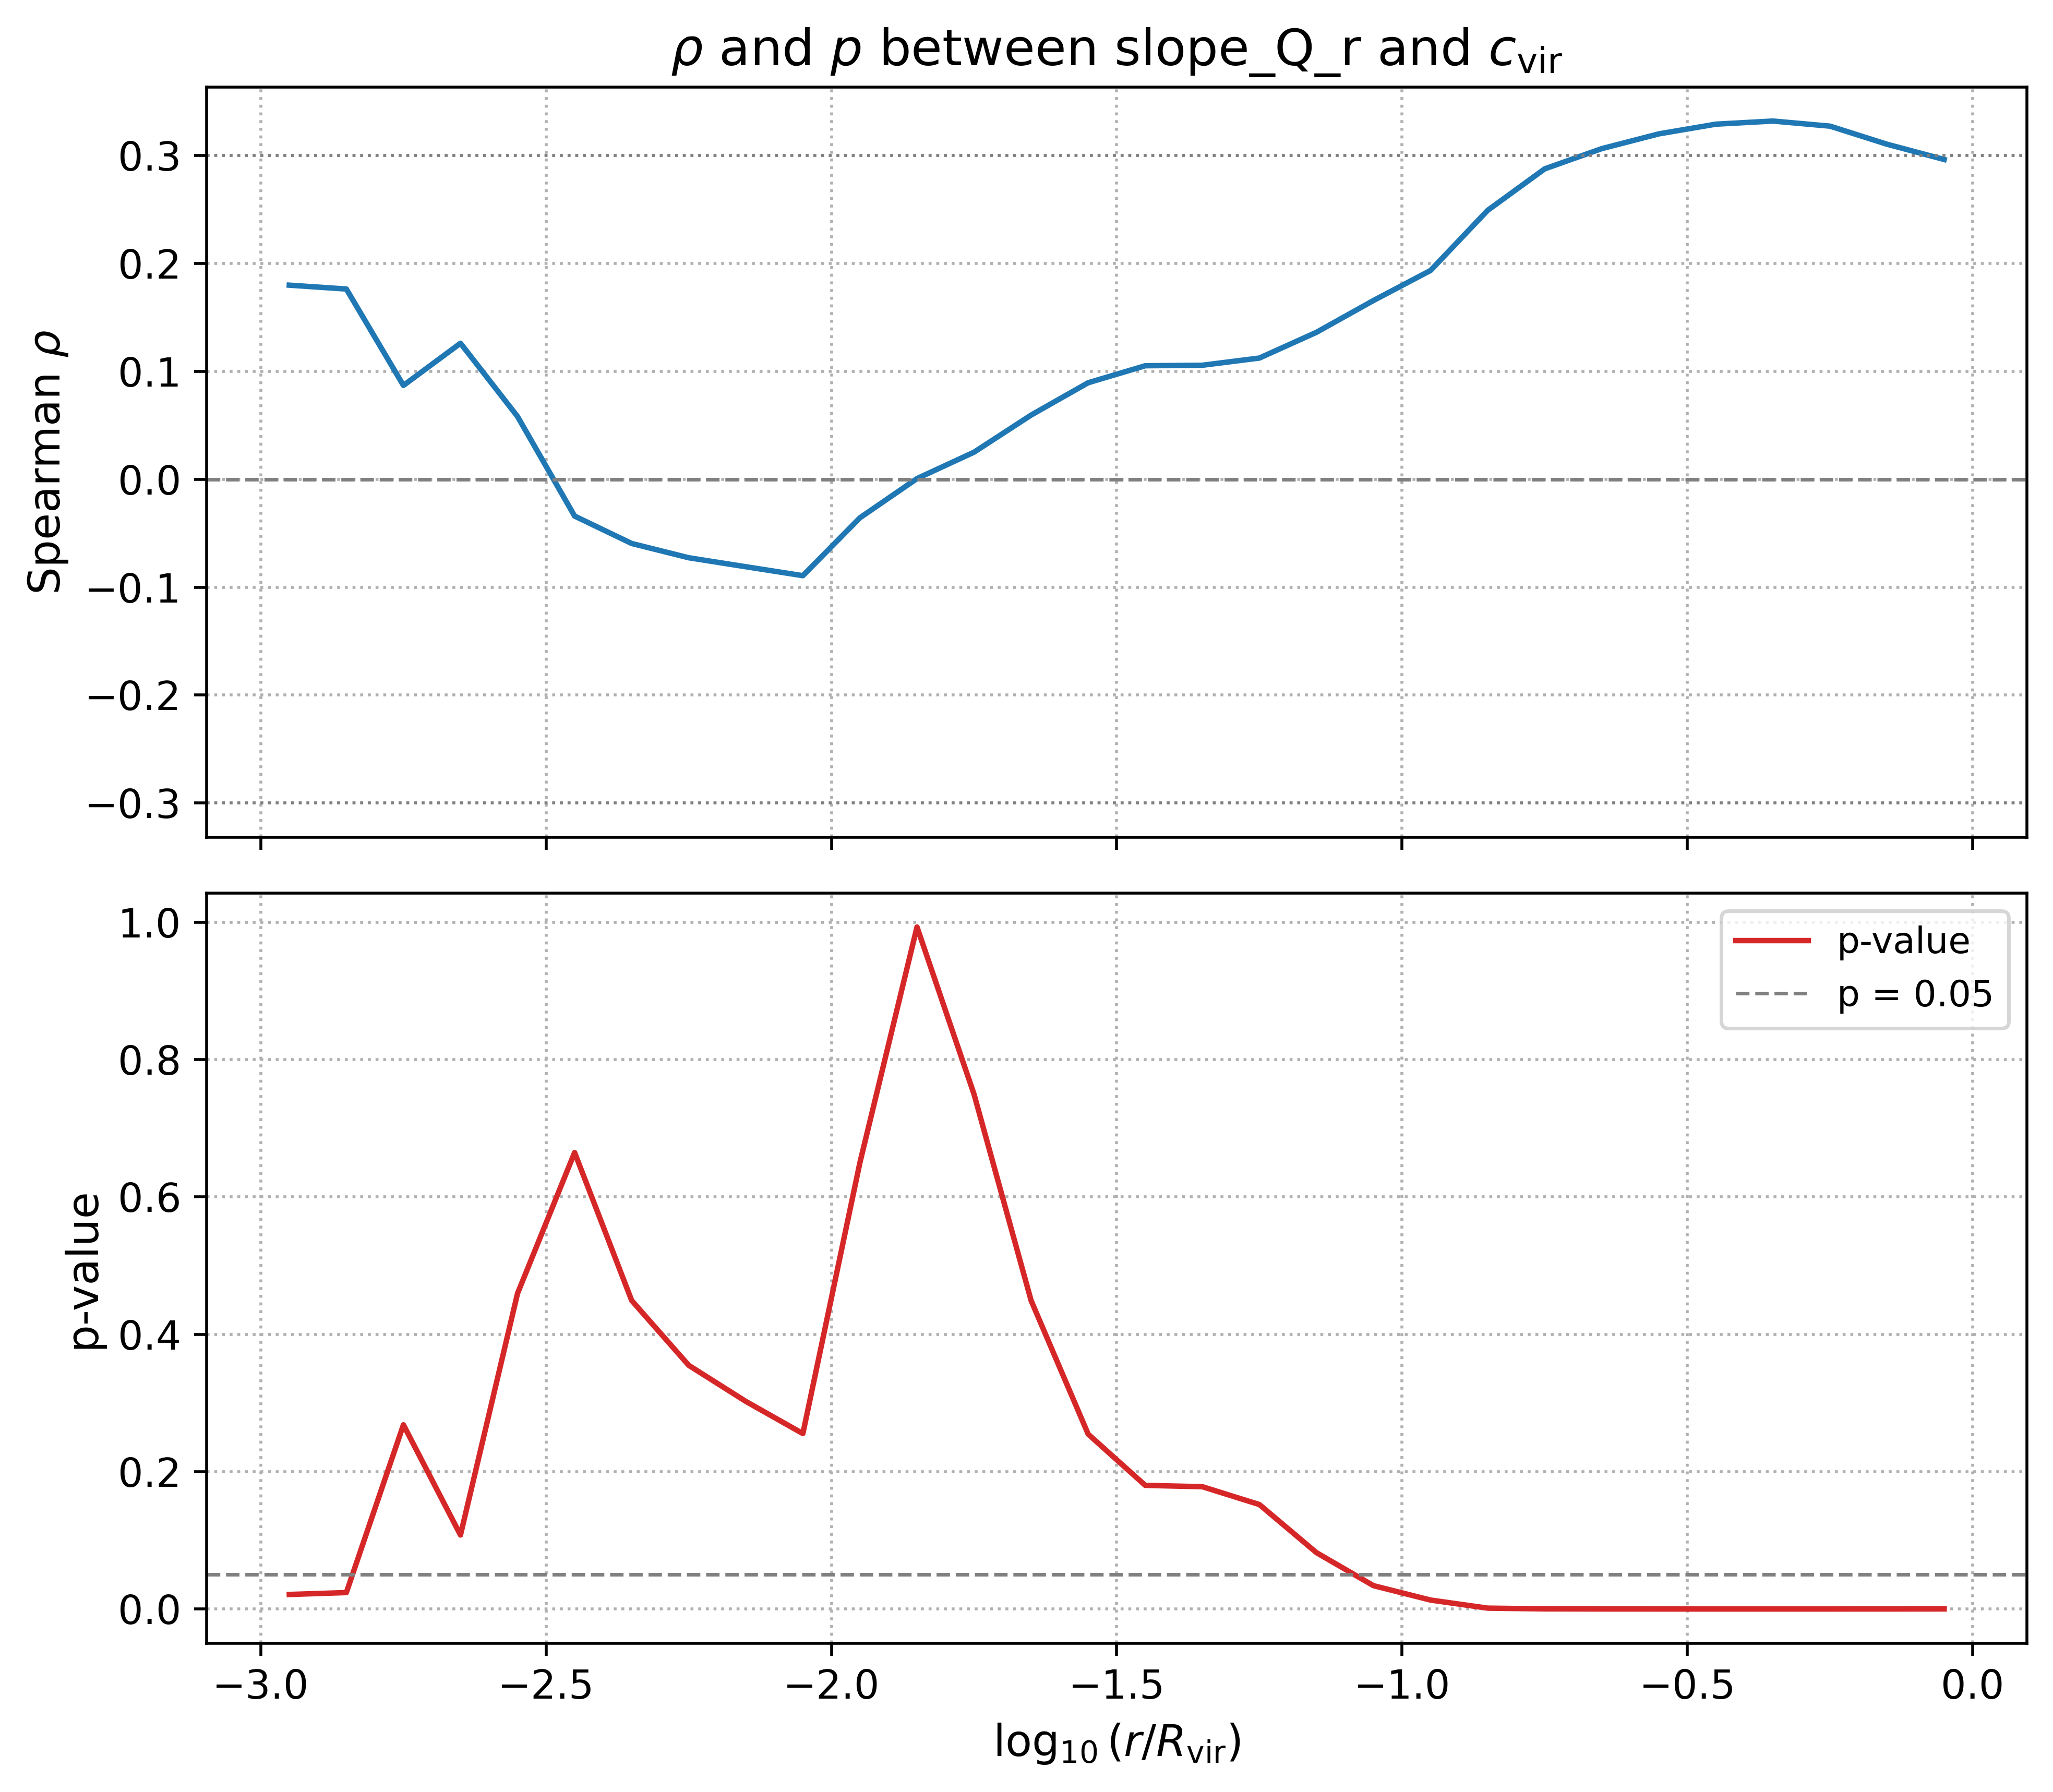

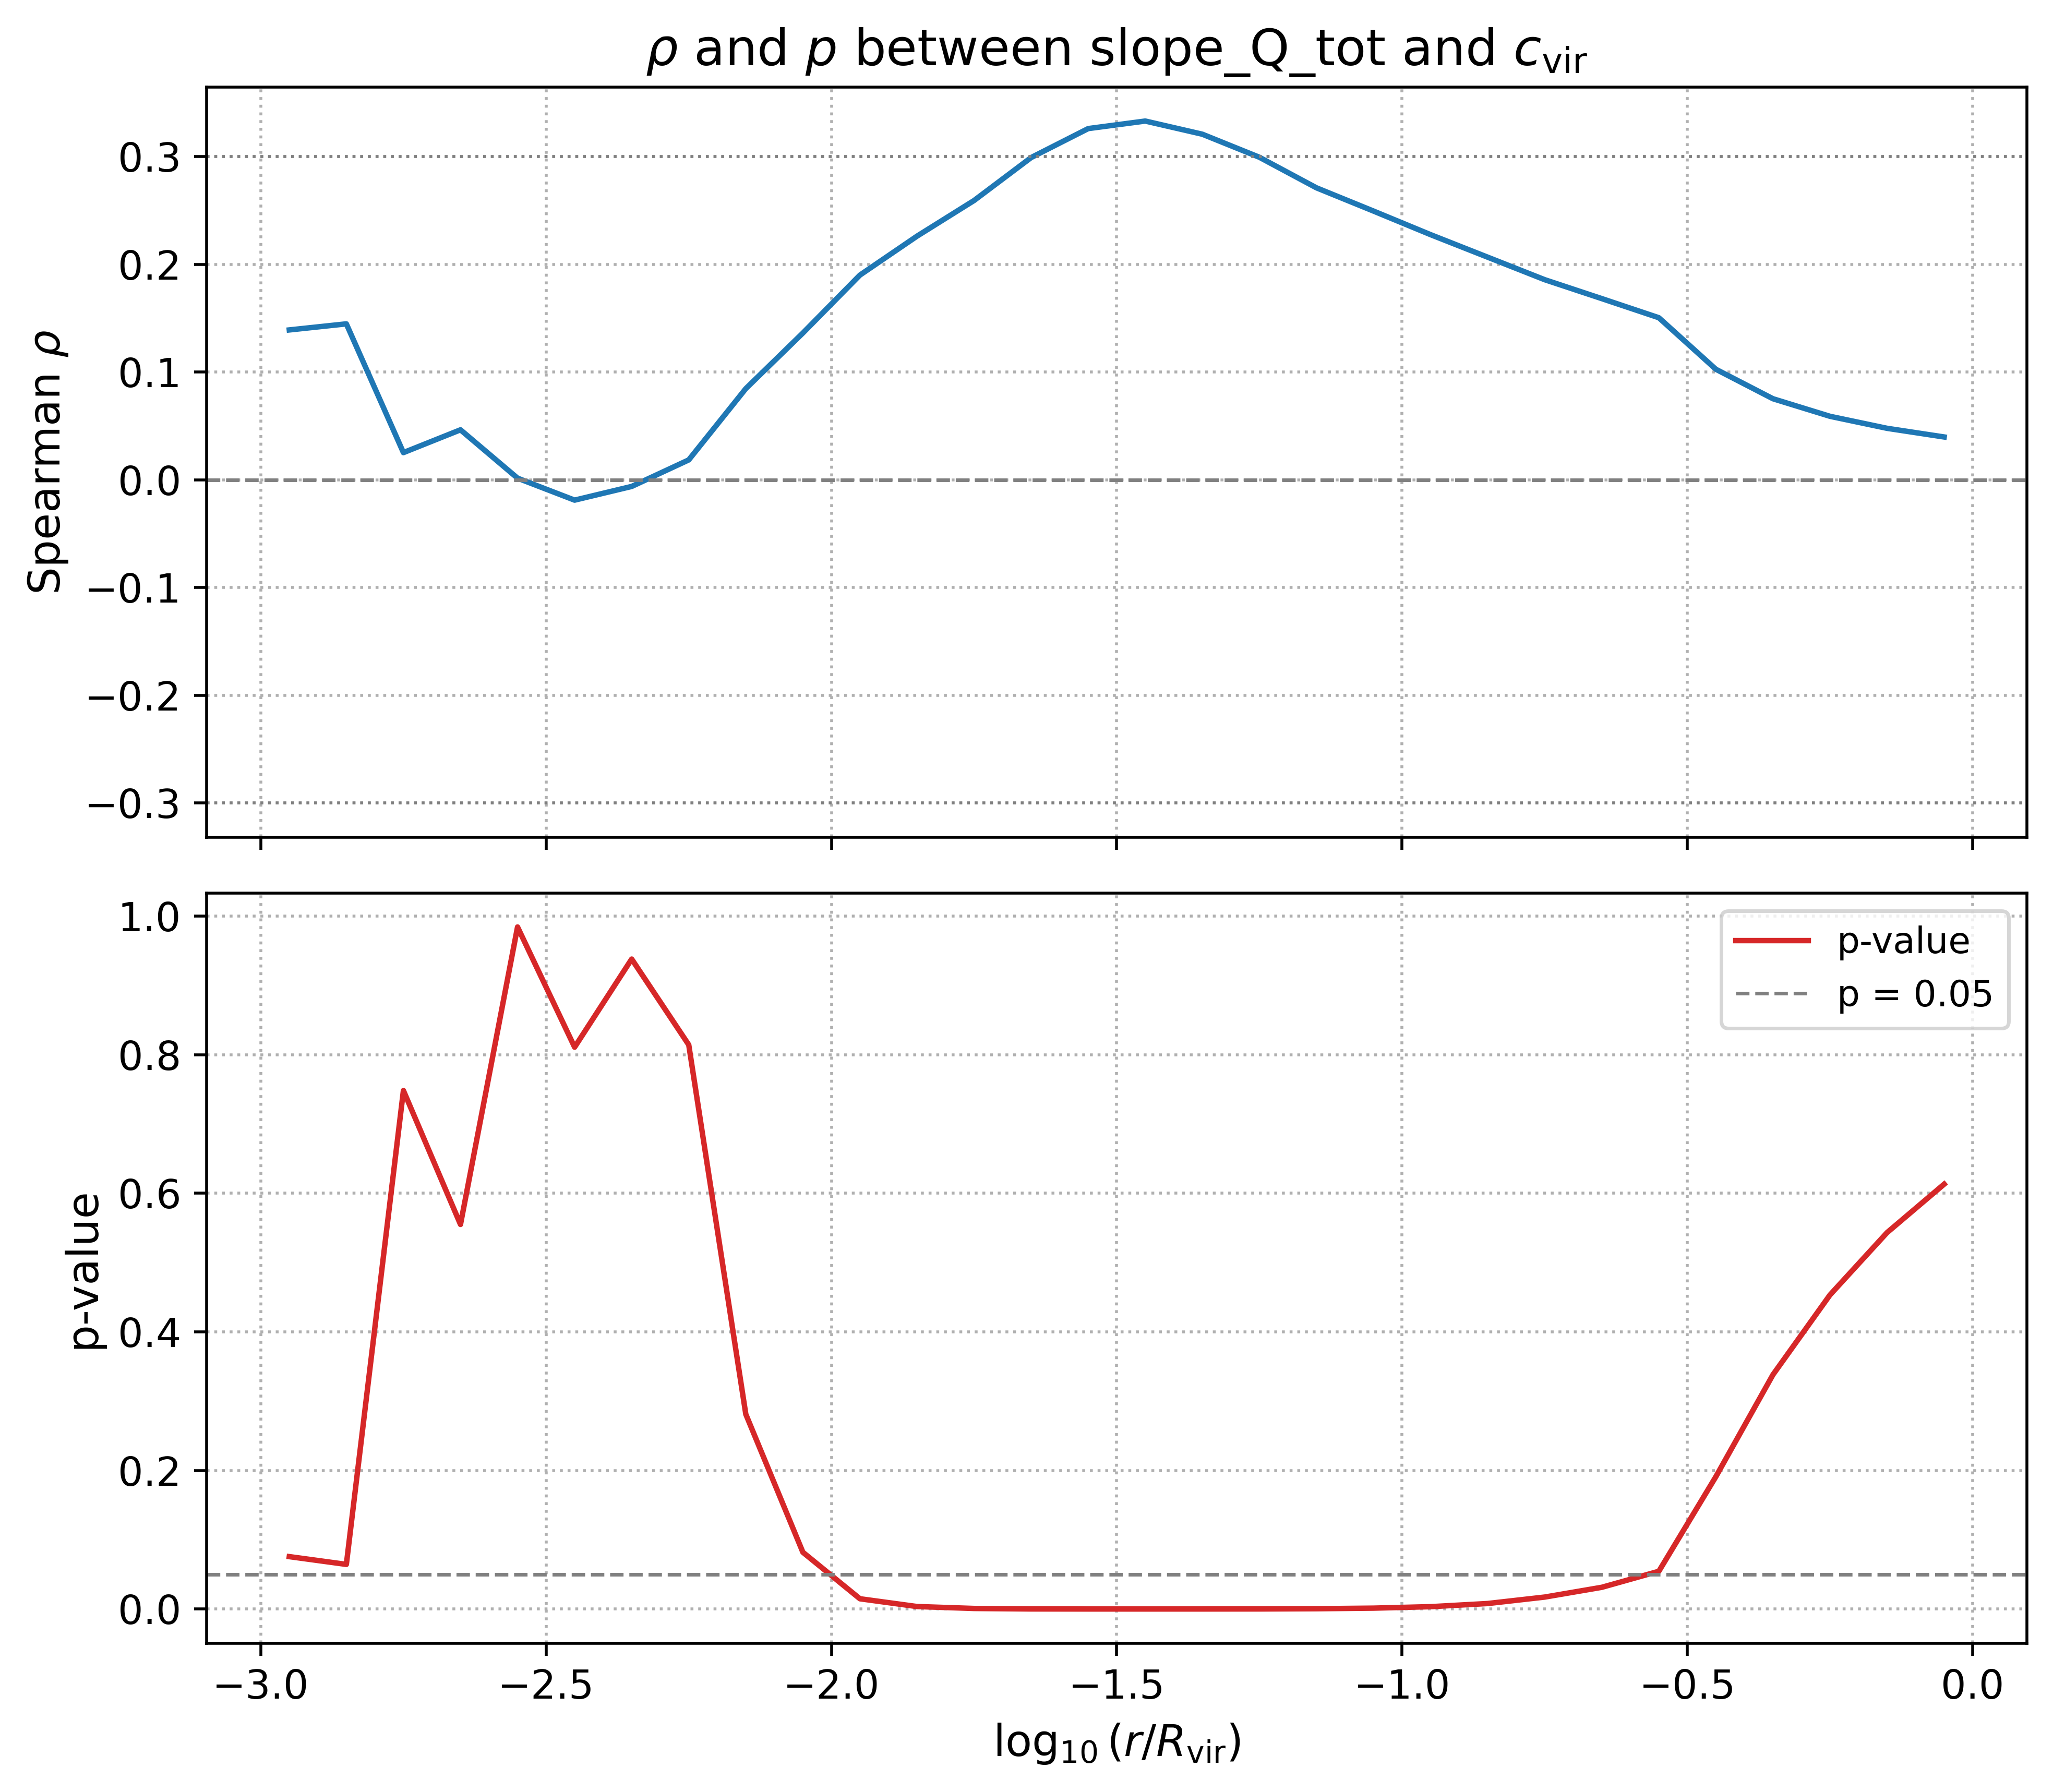

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def plot_spearman_r_vs_radius(base_dir, suite_names, x_var="cvir", slope_var="slope_Q_r",
                               log_r_min=-3, log_r_max=0.0, dlogr=0.1):
    """
    Compute and plot Spearman ρ and p as a function of radius between slope and concentration/accretion.
    """
    r_grid = np.logspace(log_r_min, log_r_max, int((log_r_max - log_r_min) / dlogr) + 1)
    r_centers = 10**((np.log10(r_grid[:-1]) + np.log10(r_grid[1:])) / 2)
    rho_vals, p_vals = [], []

    for i in range(len(r_grid) - 1):
        r_lo, r_hi = r_grid[i], r_grid[i+1]
        slopes, xs = [], []

        for suite in suite_names:
            slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
            cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
            gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")

            try:
                cvir_dict = dict(zip(pd.read_csv(cvir_path)["halo_id"], pd.read_csv(cvir_path)["cvir"]))
                gamma_dict = dict(zip(pd.read_csv(gamma_path)["halo_index"], pd.read_csv(gamma_path)["gamma"]))
            except Exception as e:
                print(f"[Warning] Failed to load metadata for {suite}: {e}")
                continue

            for f in sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")]):
                try:
                    halo_id = int(f.split("_")[1])
                    df = pd.read_csv(os.path.join(slope_dir, f))
                    r = df["r_scaled"].values
                    slope = df[slope_var].values
                    x = cvir_dict.get(halo_id) if x_var == "cvir" else gamma_dict.get(halo_id)

                    if x is None or not np.isfinite(x):
                        continue

                    in_bin = (r >= r_lo) & (r < r_hi)
                    slope_bin = slope[in_bin]
                    if slope_bin.size > 0 and np.any(np.isfinite(slope_bin)):
                        slopes.append(np.nanmean(slope_bin))
                        xs.append(x)
                except Exception as e:
                    print(f"[Warning] Failed to process {f} in {suite}: {e}")
                    continue

        slopes = np.array(slopes)
        xs = np.array(xs)
        valid = np.isfinite(xs) & (xs > 0) & np.isfinite(slopes)
        if np.sum(valid) < 2:
            rho_vals.append(np.nan)
            p_vals.append(np.nan)
            continue

        logx = np.log10(xs[valid]) if x_var == "gamma" else xs[valid]
        slopes = slopes[valid]

        r_val, p_val = spearmanr(logx, slopes)
        rho_vals.append(r_val)
        p_vals.append(p_val)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True, dpi=500)

    # ρ
    ax1.plot(np.log10(r_centers), rho_vals, label="Spearman ρ", color="tab:blue")
    ax1.axhline(0, ls="--", c="gray", lw=1)
    ax1.axhline(0.3, ls=":", c="gray", lw=0.8)
    ax1.axhline(-0.3, ls=":", c="gray", lw=0.8)
    ax1.set_ylabel(r"Spearman $\rho$")
    ax1.set_title(fr"$\rho$ and $p$ between {slope_var} and " + (r"$\log \gamma$" if x_var == "gamma" else r"$c_{\rm vir}$"))
    ax1.grid(True, linestyle=":")

    # p
    ax2.plot(np.log10(r_centers), p_vals, label="p-value", color="tab:red")
    ax2.axhline(0.05, ls="--", c="gray", lw=1, label="p = 0.05")
    ax2.set_xlabel(r"$\log_{10}(r / R_{\rm vir})$")
    ax2.set_ylabel("p-value")
    ax2.grid(True, linestyle=":")
    ax2.legend()

    plt.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster"
]

plot_spearman_r_vs_radius(base_dir, suite_names, x_var="cvir", slope_var="slope_Q_r")

plot_spearman_r_vs_radius(base_dir, suite_names, x_var="cvir", slope_var="slope_Q_tot")